# LSST SRD Redshift Distributions and Tomographic Binning
Use this notebook to generate the LSST SRD* redshift distributions (source and lens galaxy samples ofr appropriate LSST epochs) and to perform the tomographic binning of those samples.

*SRD stands for [Science Requirements Document](https://arxiv.org/abs/1809.01669)

In [1]:
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
# Old N(z) and binning procedures were in separate classes
from binning import Binning as bin
from srd_redshift_distributions import SRDRedshiftDistributions as srd
# New code has everthing in one file
from lsst_galaxy_sample import LSSTGalaxySample as lsst

## Note on the SRD redshift distributions
The overall redshift distribution of galaxies for LSST is a Smail-type parametrisation of the form:


\begin{equation}
N (z) = \left( \frac{z}{z_0}  \right) ^\beta \exp \left[ - \left( \frac{z}{z_0}  \right) ^\alpha\right] ,
\end{equation}
where $z$ is the redshift, $z_0$ is the pivot redshift, and $\alpha$ and $\beta$ the power law indices. The pivot redshfit and power law indices have different values for lens and source galaxies and for forecast years. These values are stored in the parameters.yaml file and the details can be found in the [LSST DESC Science Requirement Document (SRD)](https://arxiv.org/abs/1809.01669)

The function `get_redshfit_distribution()` from the `SRDRedshiftDistributions` class will output the redshift distribution. The redshift distribution will be normalised by default. This can be omitted by setting the normalisation argument to False. 
There is also a default setting to automatically save the redshfit range and the redshift distribution to a .csv file. If you do not wish to export the result to file, change the argument save_file to False.

## Generate the redshift distributions and bins for old and new code

In [2]:
# First we set up some prelims here
# Define the redshift intervals and forecast years
forecast_years = ["1", "10"]  # LSST forecasting epochs
normalization_options = [False, True]  # Store both normalized and non-normalized distributions
num_z_values = [300, 2000]  # Different redshift resolutions
num_dec = 3  # Decimal places; we need this to test our bin center code

In [5]:
# Now we construct results from the old code
# Create a dictionary to store all generated data
old_data = {}

# Generate and store redshift distributions, bins, and bin centers
for year in forecast_years:
    old_data[year] = {}

    for norm in normalization_options:
        norm_key = "normalized" if norm else "raw"
        old_data[year][norm_key] = {}

        for num_z in num_z_values:
            old_data[year][norm_key][num_z] = {}

            # Define the redshift range based on num_z
            redshift_range = np.linspace(0.0, 3.5, num_z)

            # Generate redshift distributions
            src_nz = srd(redshift_range, galaxy_sample="source_sample", forecast_year=year)
            lens_nz = srd(redshift_range, galaxy_sample="lens_sample", forecast_year=year)
            old_data[year][norm_key][num_z]["source_sample"] = src_nz.get_redshift_distribution(normalized=norm,
                                                                                                     save_file=False)
            old_data[year][norm_key][num_z]["lens_sample"] = lens_nz.get_redshift_distribution(normalized=norm,
                                                                                                 save_file=False)
            # Generate bins
            src_bin = bin(redshift_range, old_data[year][norm_key][num_z]["source_sample"], year)
            lens_bin = bin(redshift_range, old_data[year][norm_key][num_z]["lens_sample"], year)
            old_data[year][norm_key][num_z]["source_bins"] = src_bin.source_bins(normalized=norm, save_file=False)
            old_data[year][norm_key][num_z]["lens_bins"] = lens_bin.lens_bins(normalized=norm, save_file=False)
            # Compute bin centers
            old_data[year][norm_key][num_z]["source_bin_centers"] = src_bin.get_bin_centers(save_file=False,
                                                                                            decimal_places=num_dec)
            old_data[year][norm_key][num_z]["lens_bin_centers"] = lens_bin.get_bin_centers(save_file=False,
                                                                                           decimal_places=num_dec)

# Access the data:
# old_data["1"]["normalized"][300]["source_sample"]  # Normalized source sample for Year 1 with 300 redshift points
# old_data["10"]["raw"][2000]["lens_bins"]  # Unnormalized lens bins for Year 10 with 2000 redshift points
# old_data["1"]["normalized"][300]["source_bin_centers"]  # Bin centers for sources Year 1 with 300 redshift points


In [77]:
new_data["1"]["normalized"][300]["source_bin_centers"]

{0: 0.251, 1: 0.456, 2: 0.655, 3: 0.917, 4: 1.527}

In [6]:
# We now use the new code to construct the same products

# Create a dictionary to store all newly generated data
new_data = {}

# Generate and store redshift distributions and bins
for year in forecast_years:
    new_data[year] = {}

    for norm in normalization_options:
        norm_key = "normalized" if norm else "raw"
        new_data[year][norm_key] = {}

        for num_z in num_z_values:
            new_data[year][norm_key][num_z] = {}

            # Define the redshift range based on num_z
            redshift_range = np.linspace(0.0, 3.5, num_z)

            # Initialize the LSST sample generator
            init = lsst(year, redshift_range)

            # Generate redshift distributions
            new_data[year][norm_key][num_z]["source_sample"] = init.source_sample(normalized=norm, save_file=True)
            new_data[year][norm_key][num_z]["lens_sample"] = init.lens_sample(normalized=norm, save_file=True)
            # Generate bins
            new_data[year][norm_key][num_z]["source_bins"] = init.source_bins(normalized=norm, save_file=True)
            new_data[year][norm_key][num_z]["lens_bins"] = init.lens_bins(normalized=norm, save_file=True)
            # Compute bin centers
            new_data[year][norm_key][num_z]["source_bin_centers"] = init.source_bin_centers(decimal_places=num_dec)
            new_data[year][norm_key][num_z]["lens_bin_centers"] = init.lens_bin_centers(decimal_places=num_dec)

# Access the data:
# new_data["1"]["normalized"][300]["source_sample"]  # Normalized source sample for Year 1 with 300 redshift points
# new_data["10"]["raw"][2000]["lens_bins"]  # Unnormalized lens bins for Year 10 with 2000 redshift points


# Plot LSST Lens and Source Sample Distributions

In [7]:
# Set global line width and font sizes
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 15

## First comparison: Years 1 and 10, Normalized, 300 redshift points

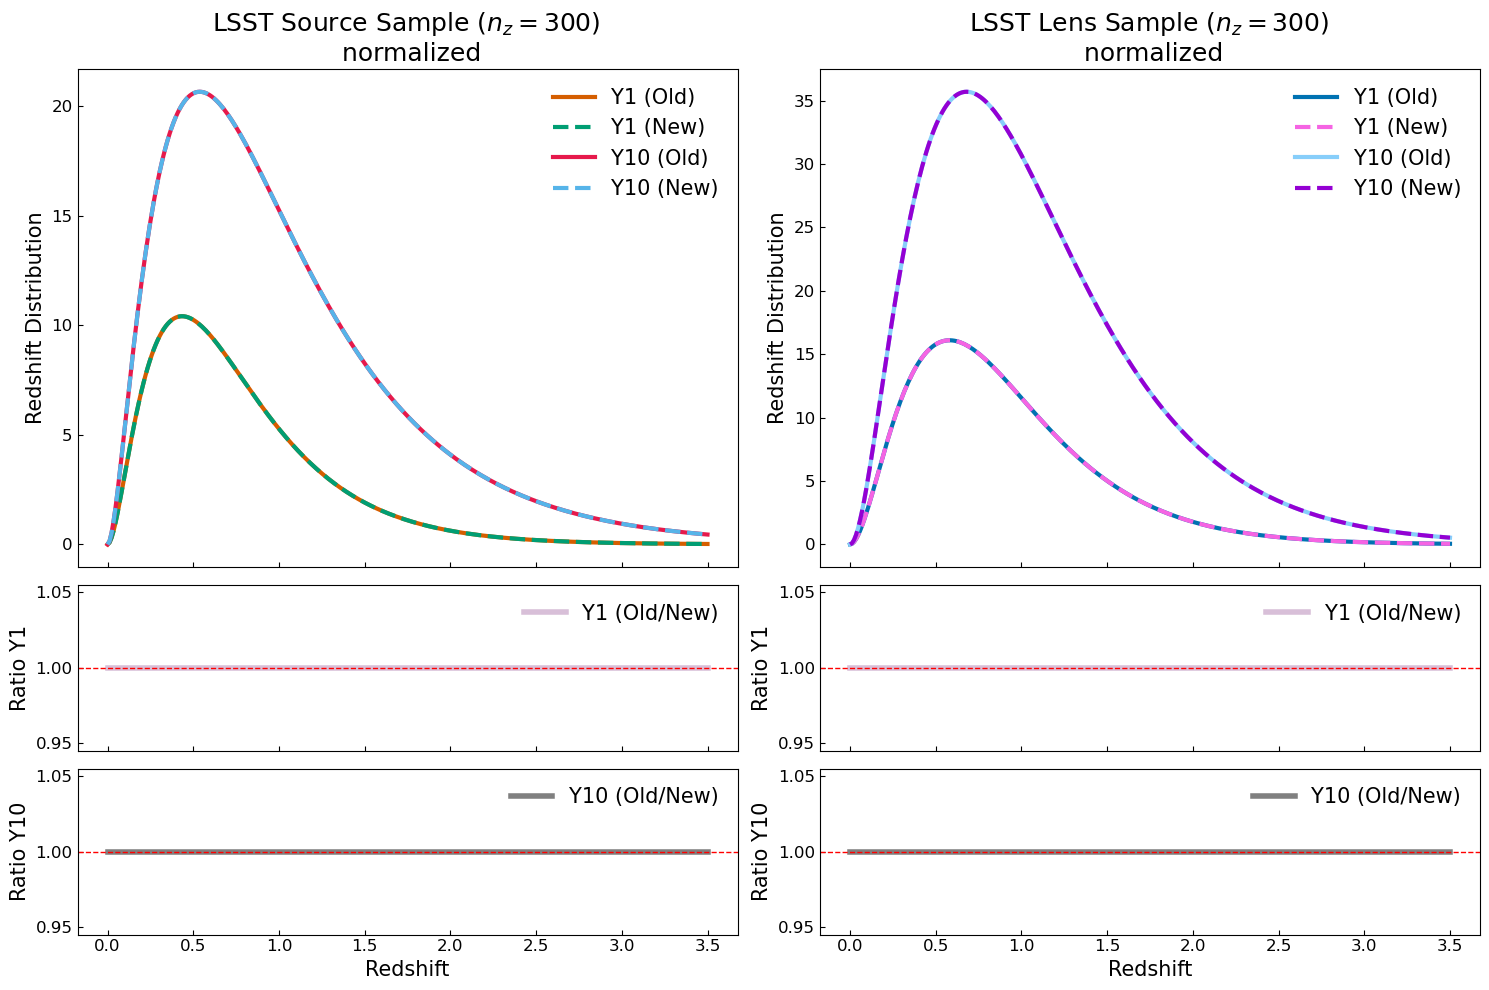

In [44]:
# Define the parameters for comparison
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"  # Change to "raw" if you want unnormalized data
num_z = 300

# Define colors for each year and sample type
colors_old = {'source_sample': '#D55E00', 'lens_sample': '#0072B2'}
colors_old_y10 = {'source_sample': '#E6194B', 'lens_sample': 'lightskyblue'}
colors_new = {'source_sample': '#009E73', 'lens_sample': '#F564E3'}
colors_new_y10 = {'source_sample': '#56B4E9', 'lens_sample': '#9400D3'}


titles = {'source_sample': f'LSST Source Sample ($n_z={num_z}$) \n {norm_key}',
          'lens_sample': f'LSST Lens Sample ($n_z={num_z}$) \n {norm_key}'}
new_keys = {'source_sample': "source_sample", 'lens_sample': "lens_sample"}

redshift_range = np.linspace(0.0, 3.5, num_z)  # Adjust if needed

# Create a 3x2 subplot grid with different height ratios
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

# Top row: Redshift distributions for Year 1 and Year 10
for ax, sample_type in zip(axs[0], ["source_sample", "lens_sample"]):
    for year in years:
        color_old = colors_old[sample_type] if year == "1" else colors_old_y10[sample_type]
        color_new = colors_new[sample_type] if year == "1" else colors_new_y10[sample_type]
        linestyle_old = '-' if year == "1" else '-'
        linestyle_new = '--' if year == "1" else '--'

        # Old method: solid or dash-dot line
        ax.plot(
            redshift_range,
            old_data[year][norm_key][num_z][sample_type],
            label=f'Y{year} (Old)',
            linestyle=linestyle_old,
            color=color_old
        )

        # New method: dashed or dotted line
        ax.plot(
            redshift_range,
            new_data[year][norm_key][num_z][new_keys[sample_type]],
            label=f'Y{year} (New)',
            linestyle=linestyle_new,
            lw=3,
            color=color_new
        )

    ax.set_title(titles[sample_type])
    ax.set_ylabel('Redshift Distribution')
    ax.legend(frameon=False, loc='upper right')
    ax.tick_params(direction='in')

# Middle row: Ratio plots for Year 1 (Old/New)
for ax, sample_type in zip(axs[1], ["source_sample", "lens_sample"]):
    year = "1"  # Year 1 ratio
    old_vals = old_data[year][norm_key][num_z][sample_type]
    new_vals = new_data[year][norm_key][num_z][new_keys[sample_type]]

    # Compute ratio safely
    ratio = np.divide(old_vals, new_vals, out=np.full_like(old_vals, np.nan), where=new_vals != 0)
    ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

    ax.plot(
        redshift_range,
        ratio,
        label=f'Y{year} (Old/New)',
        linestyle='-',
        lw=4,
        color='thistle'
    )

    ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
    ax.set_ylabel('Ratio Y1')
    ax.tick_params(direction='in')
    ax.legend(frameon=False, loc='upper right')

# Bottom row: Ratio plots for Year 10 (Old/New)
for ax, sample_type in zip(axs[2], ["source_sample", "lens_sample"]):
    year = "10"  # Year 10 ratio
    old_vals = old_data[year][norm_key][num_z][sample_type]
    new_vals = new_data[year][norm_key][num_z][new_keys[sample_type]]

    # Compute ratio safely
    ratio = np.divide(old_vals, new_vals, out=np.full_like(old_vals, np.nan), where=new_vals != 0)
    ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

    ax.plot(
        redshift_range,
        ratio,
        label=f'Y{year} (Old/New)',
        linestyle='-',
        lw=4,
        color='gray'
    )

    ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Ratio Y10')
    ax.tick_params(direction='in')
    ax.legend(frameon=False, loc='upper right')

plt.tight_layout()
plt.show()


## Second comparison: Years 1 and 10, Normalized, 2000 redshift points

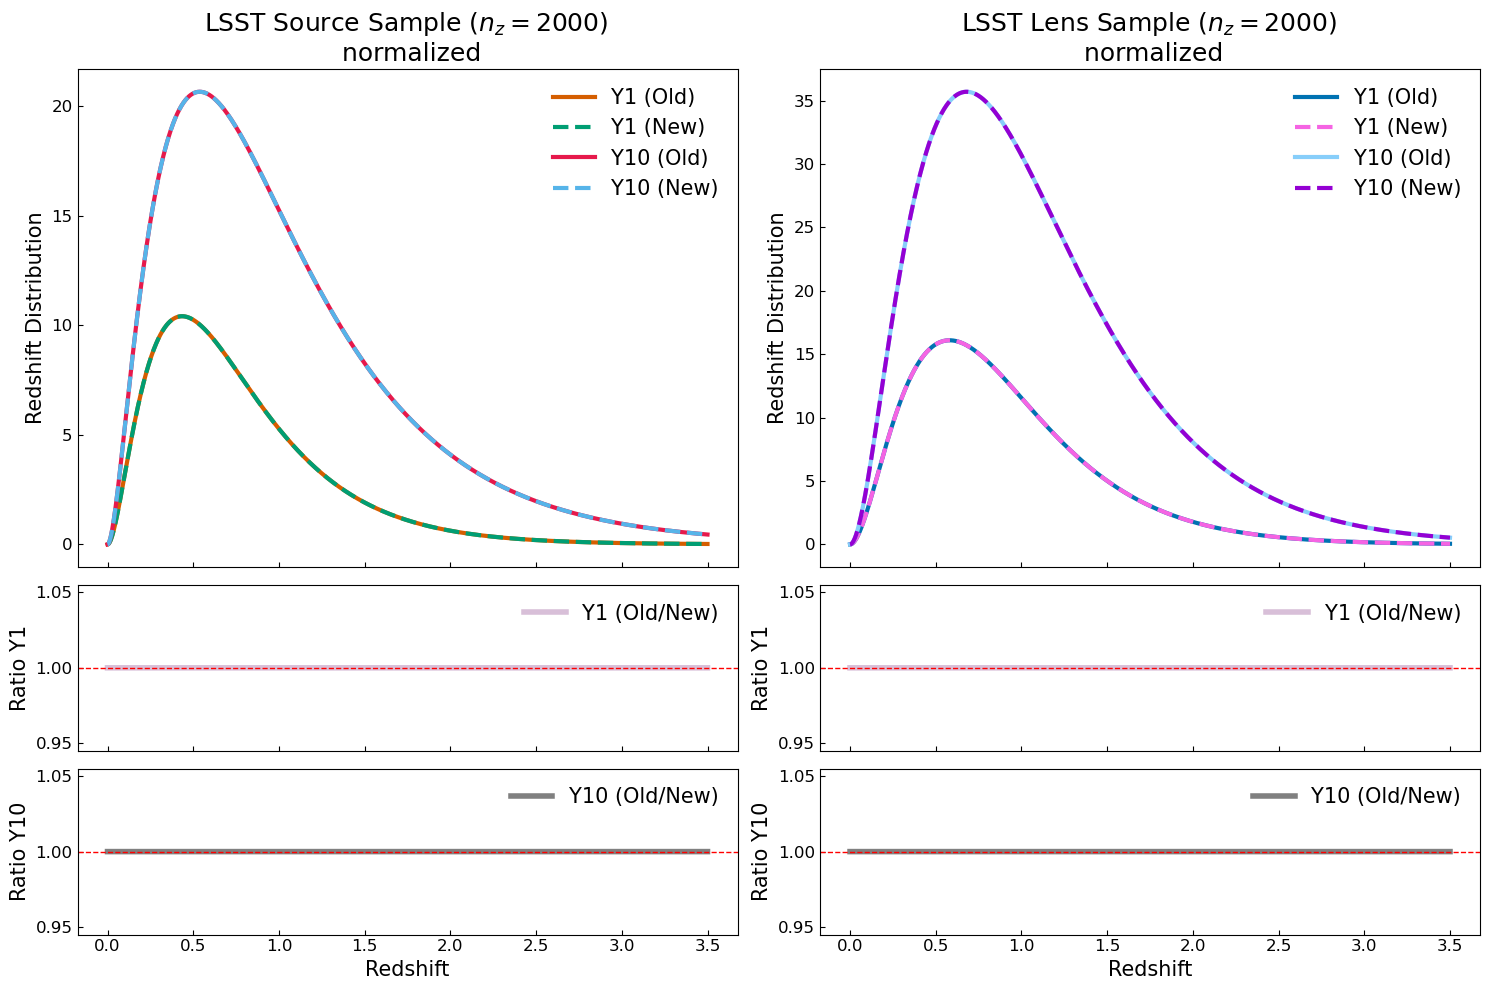

In [45]:
# Define the parameters for comparison
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"  # Change to "raw" if you want unnormalized data
num_z = 2000

# Define colors for each year and sample type
colors_old = {'source_sample': '#D55E00', 'lens_sample': '#0072B2'}
colors_old_y10 = {'source_sample': '#E6194B', 'lens_sample': 'lightskyblue'}
colors_new = {'source_sample': '#009E73', 'lens_sample': '#F564E3'}
colors_new_y10 = {'source_sample': '#56B4E9', 'lens_sample': '#9400D3'}


titles = {'source_sample': f'LSST Source Sample ($n_z={num_z}$) \n {norm_key}',
          'lens_sample': f'LSST Lens Sample ($n_z={num_z}$) \n {norm_key}'}
new_keys = {'source_sample': "source_sample", 'lens_sample': "lens_sample"}

redshift_range = np.linspace(0.0, 3.5, num_z)  # Adjust if needed

# Create a 3x2 subplot grid with different height ratios
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

# Top row: Redshift distributions for Year 1 and Year 10
for ax, sample_type in zip(axs[0], ["source_sample", "lens_sample"]):
    for year in years:
        color_old = colors_old[sample_type] if year == "1" else colors_old_y10[sample_type]
        color_new = colors_new[sample_type] if year == "1" else colors_new_y10[sample_type]
        linestyle_old = '-' if year == "1" else '-'
        linestyle_new = '--' if year == "1" else '--'

        # Old method: solid or dash-dot line
        ax.plot(
            redshift_range,
            old_data[year][norm_key][num_z][sample_type],
            label=f'Y{year} (Old)',
            linestyle=linestyle_old,
            color=color_old
        )

        # New method: dashed or dotted line
        ax.plot(
            redshift_range,
            new_data[year][norm_key][num_z][new_keys[sample_type]],
            label=f'Y{year} (New)',
            linestyle=linestyle_new,
            lw=3,
            color=color_new
        )

    ax.set_title(titles[sample_type])
    ax.set_ylabel('Redshift Distribution')
    ax.legend(frameon=False, loc='upper right')
    ax.tick_params(direction='in')

# Middle row: Ratio plots for Year 1 (Old/New)
for ax, sample_type in zip(axs[1], ["source_sample", "lens_sample"]):
    year = "1"  # Year 1 ratio
    old_vals = old_data[year][norm_key][num_z][sample_type]
    new_vals = new_data[year][norm_key][num_z][new_keys[sample_type]]

    # Compute ratio safely
    ratio = np.divide(old_vals, new_vals, out=np.full_like(old_vals, np.nan), where=new_vals != 0)
    ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

    ax.plot(
        redshift_range,
        ratio,
        label=f'Y{year} (Old/New)',
        linestyle='-',
        lw=4,
        color='thistle'
    )

    ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
    ax.set_ylabel('Ratio Y1')
    ax.tick_params(direction='in')
    ax.legend(frameon=False, loc='upper right')

# Bottom row: Ratio plots for Year 10 (Old/New)
for ax, sample_type in zip(axs[2], ["source_sample", "lens_sample"]):
    year = "10"  # Year 10 ratio
    old_vals = old_data[year][norm_key][num_z][sample_type]
    new_vals = new_data[year][norm_key][num_z][new_keys[sample_type]]

    # Compute ratio safely
    ratio = np.divide(old_vals, new_vals, out=np.full_like(old_vals, np.nan), where=new_vals != 0)
    ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

    ax.plot(
        redshift_range,
        ratio,
        label=f'Y{year} (Old/New)',
        linestyle='-',
        lw=4,
        color='gray'
    )

    ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Ratio Y10')
    ax.tick_params(direction='in')
    ax.legend(frameon=False, loc='upper right')

plt.tight_layout()
plt.show()


## Third comparison: Years 1 and 10, unnormalized, 300 redshift points

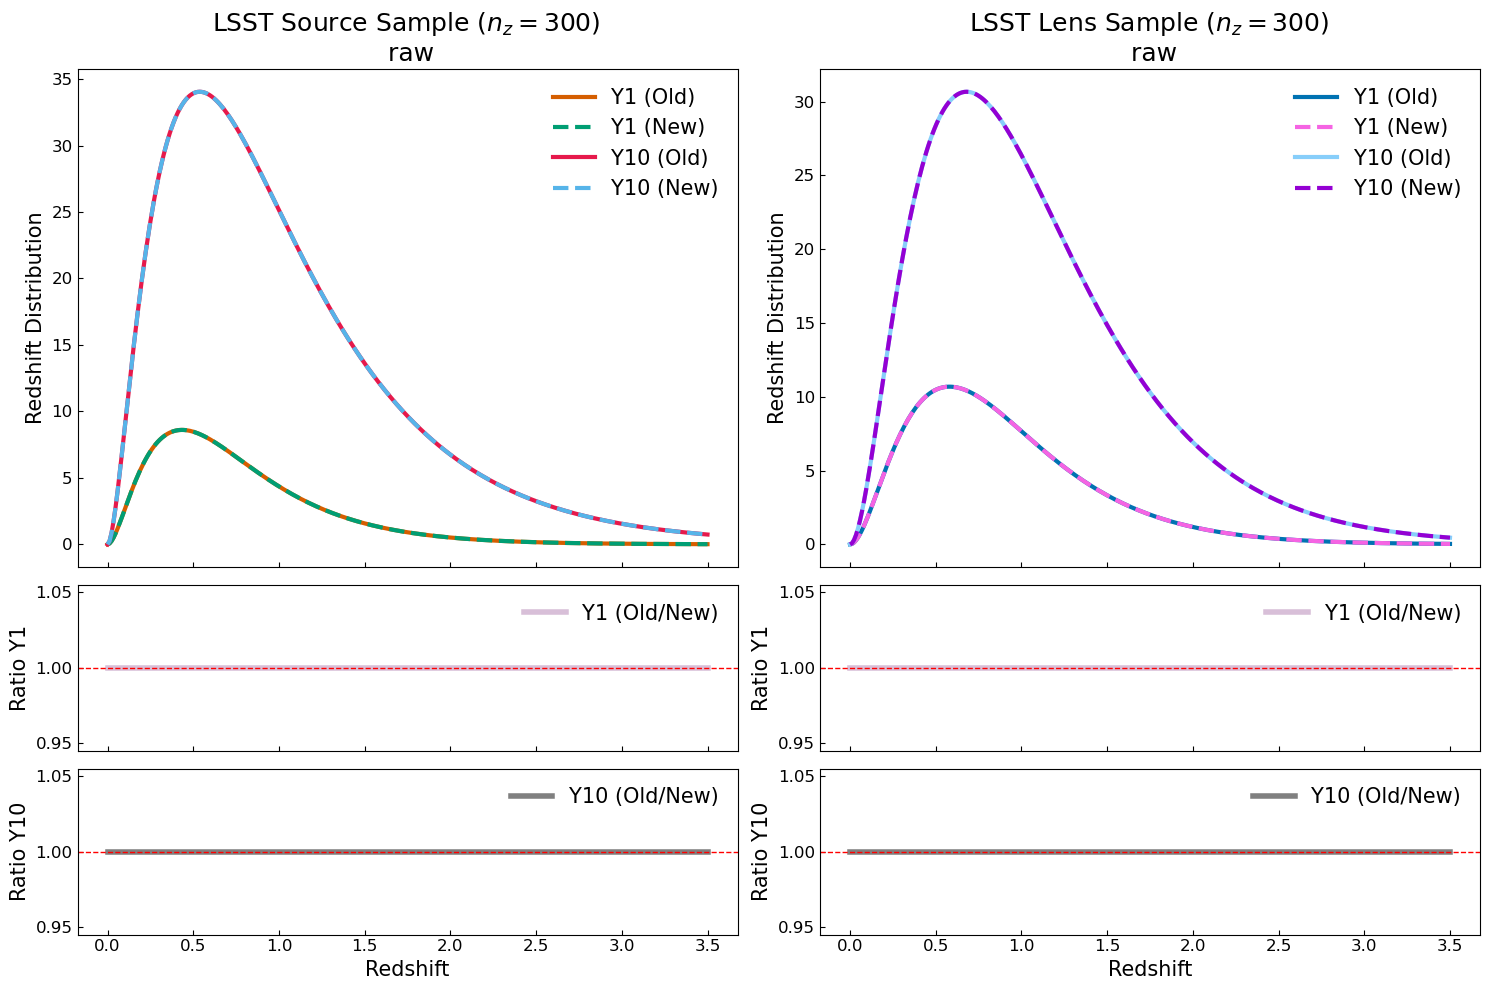

In [46]:
# Define the parameters for comparison
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z = 300

# Define colors for each year and sample type
colors_old = {'source_sample': '#D55E00', 'lens_sample': '#0072B2'}
colors_old_y10 = {'source_sample': '#E6194B', 'lens_sample': 'lightskyblue'}
colors_new = {'source_sample': '#009E73', 'lens_sample': '#F564E3'}
colors_new_y10 = {'source_sample': '#56B4E9', 'lens_sample': '#9400D3'}


titles = {'source_sample': f'LSST Source Sample ($n_z={num_z}$) \n {norm_key}',
          'lens_sample': f'LSST Lens Sample ($n_z={num_z}$) \n {norm_key}'}
new_keys = {'source_sample': "source_sample", 'lens_sample': "lens_sample"}

redshift_range = np.linspace(0.0, 3.5, num_z)  # Adjust if needed

# Create a 3x2 subplot grid with different height ratios
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

# Top row: Redshift distributions for Year 1 and Year 10
for ax, sample_type in zip(axs[0], ["source_sample", "lens_sample"]):
    for year in years:
        color_old = colors_old[sample_type] if year == "1" else colors_old_y10[sample_type]
        color_new = colors_new[sample_type] if year == "1" else colors_new_y10[sample_type]
        linestyle_old = '-' if year == "1" else '-'
        linestyle_new = '--' if year == "1" else '--'

        # Old method: solid or dash-dot line
        ax.plot(
            redshift_range,
            old_data[year][norm_key][num_z][sample_type],
            label=f'Y{year} (Old)',
            linestyle=linestyle_old,
            color=color_old
        )

        # New method: dashed or dotted line
        ax.plot(
            redshift_range,
            new_data[year][norm_key][num_z][new_keys[sample_type]],
            label=f'Y{year} (New)',
            linestyle=linestyle_new,
            lw=3,
            color=color_new
        )

    ax.set_title(titles[sample_type])
    ax.set_ylabel('Redshift Distribution')
    ax.legend(frameon=False, loc='upper right')
    ax.tick_params(direction='in')

# Middle row: Ratio plots for Year 1 (Old/New)
for ax, sample_type in zip(axs[1], ["source_sample", "lens_sample"]):
    year = "1"  # Year 1 ratio
    old_vals = old_data[year][norm_key][num_z][sample_type]
    new_vals = new_data[year][norm_key][num_z][new_keys[sample_type]]

    # Compute ratio safely
    ratio = np.divide(old_vals, new_vals, out=np.full_like(old_vals, np.nan), where=new_vals != 0)
    ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

    ax.plot(
        redshift_range,
        ratio,
        label=f'Y{year} (Old/New)',
        linestyle='-',
        lw=4,
        color='thistle'
    )

    ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
    ax.set_ylabel('Ratio Y1')
    ax.tick_params(direction='in')
    ax.legend(frameon=False, loc='upper right')

# Bottom row: Ratio plots for Year 10 (Old/New)
for ax, sample_type in zip(axs[2], ["source_sample", "lens_sample"]):
    year = "10"  # Year 10 ratio
    old_vals = old_data[year][norm_key][num_z][sample_type]
    new_vals = new_data[year][norm_key][num_z][new_keys[sample_type]]

    # Compute ratio safely
    ratio = np.divide(old_vals, new_vals, out=np.full_like(old_vals, np.nan), where=new_vals != 0)
    ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

    ax.plot(
        redshift_range,
        ratio,
        label=f'Y{year} (Old/New)',
        linestyle='-',
        lw=4,
        color='gray'
    )

    ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Ratio Y10')
    ax.tick_params(direction='in')
    ax.legend(frameon=False, loc='upper right')

plt.tight_layout()
plt.show()


## Fourth comparison: Years 1 and 10, unnormalized, 2000 redshift points

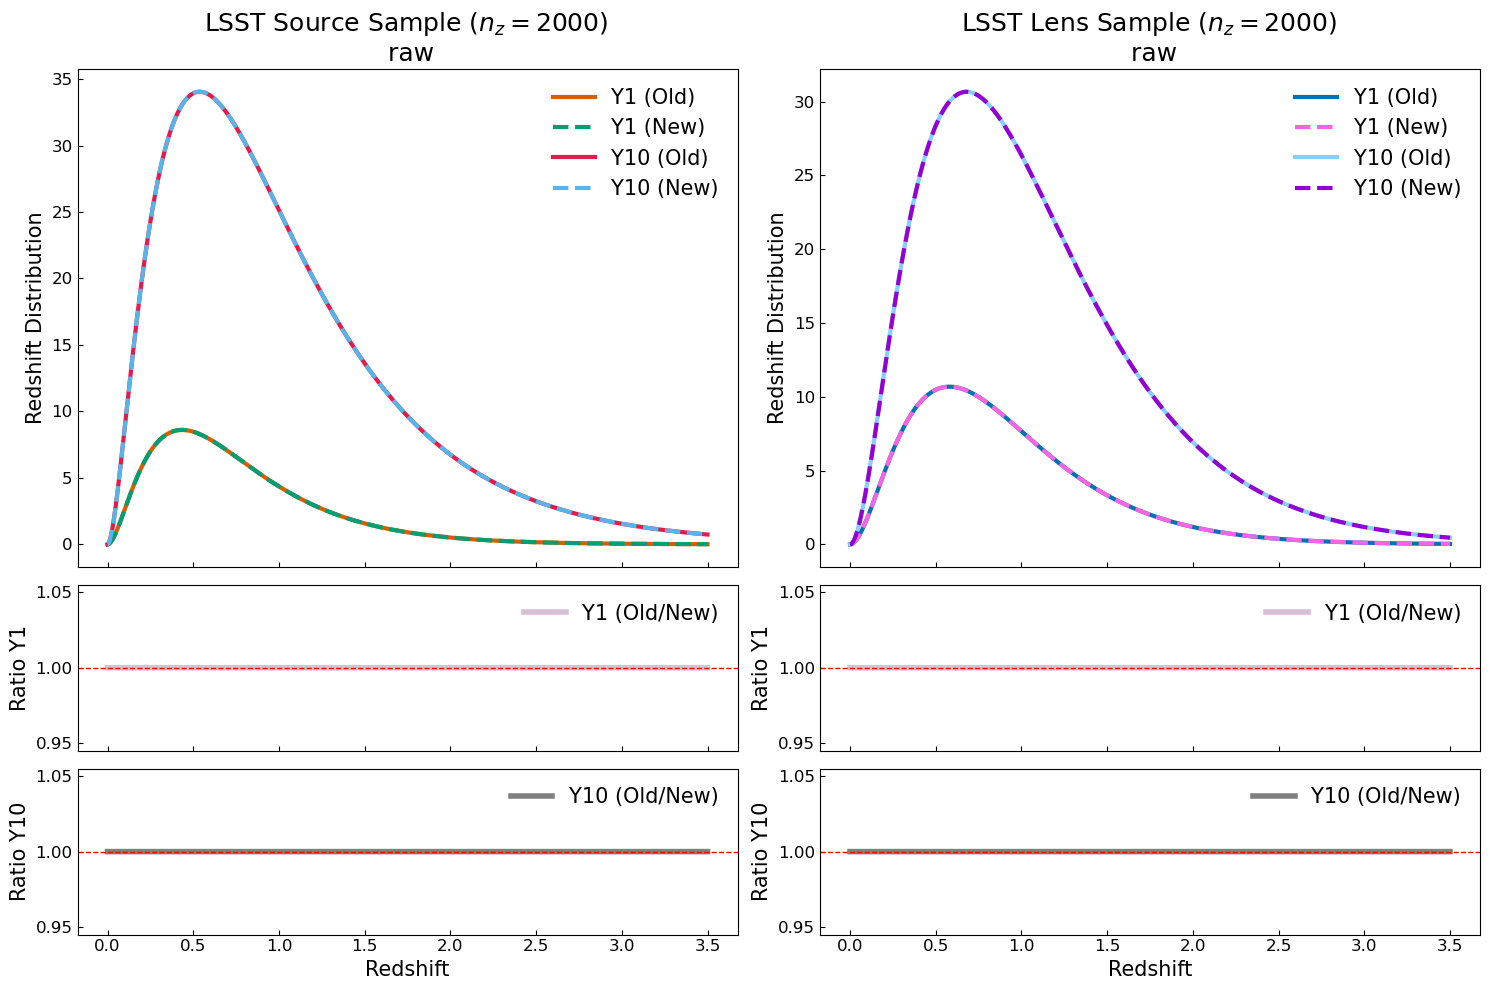

In [47]:
# Define the parameters for comparison
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z = 2000

# Define colors for each year and sample type
colors_old = {'source_sample': '#D55E00', 'lens_sample': '#0072B2'}
colors_old_y10 = {'source_sample': '#E6194B', 'lens_sample': 'lightskyblue'}
colors_new = {'source_sample': '#009E73', 'lens_sample': '#F564E3'}
colors_new_y10 = {'source_sample': '#56B4E9', 'lens_sample': '#9400D3'}


titles = {'source_sample': f'LSST Source Sample ($n_z={num_z}$) \n {norm_key}',
          'lens_sample': f'LSST Lens Sample ($n_z={num_z}$) \n {norm_key}'}
new_keys = {'source_sample': "source_sample", 'lens_sample': "lens_sample"}

redshift_range = np.linspace(0.0, 3.5, num_z)  # Adjust if needed

# Create a 3x2 subplot grid with different height ratios
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

# Top row: Redshift distributions for Year 1 and Year 10
for ax, sample_type in zip(axs[0], ["source_sample", "lens_sample"]):
    for year in years:
        color_old = colors_old[sample_type] if year == "1" else colors_old_y10[sample_type]
        color_new = colors_new[sample_type] if year == "1" else colors_new_y10[sample_type]
        linestyle_old = '-' if year == "1" else '-'
        linestyle_new = '--' if year == "1" else '--'

        # Old method: solid or dash-dot line
        ax.plot(
            redshift_range,
            old_data[year][norm_key][num_z][sample_type],
            label=f'Y{year} (Old)',
            linestyle=linestyle_old,
            color=color_old
        )

        # New method: dashed or dotted line
        ax.plot(
            redshift_range,
            new_data[year][norm_key][num_z][new_keys[sample_type]],
            label=f'Y{year} (New)',
            linestyle=linestyle_new,
            lw=3,
            color=color_new
        )

    ax.set_title(titles[sample_type])
    ax.set_ylabel('Redshift Distribution')
    ax.legend(frameon=False, loc='upper right')
    ax.tick_params(direction='in')

# Middle row: Ratio plots for Year 1 (Old/New)
for ax, sample_type in zip(axs[1], ["source_sample", "lens_sample"]):
    year = "1"  # Year 1 ratio
    old_vals = old_data[year][norm_key][num_z][sample_type]
    new_vals = new_data[year][norm_key][num_z][new_keys[sample_type]]

    # Compute ratio safely
    ratio = np.divide(old_vals, new_vals, out=np.full_like(old_vals, np.nan), where=new_vals != 0)
    ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

    ax.plot(
        redshift_range,
        ratio,
        label=f'Y{year} (Old/New)',
        linestyle='-',
        lw=4,
        color='thistle'
    )

    ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
    ax.set_ylabel('Ratio Y1')
    ax.tick_params(direction='in')
    ax.legend(frameon=False, loc='upper right')

# Bottom row: Ratio plots for Year 10 (Old/New)
for ax, sample_type in zip(axs[2], ["source_sample", "lens_sample"]):
    year = "10"  # Year 10 ratio
    old_vals = old_data[year][norm_key][num_z][sample_type]
    new_vals = new_data[year][norm_key][num_z][new_keys[sample_type]]

    # Compute ratio safely
    ratio = np.divide(old_vals, new_vals, out=np.full_like(old_vals, np.nan), where=new_vals != 0)
    ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

    ax.plot(
        redshift_range,
        ratio,
        label=f'Y{year} (Old/New)',
        linestyle='-',
        lw=4,
        color='gray'
    )

    ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Ratio Y10')
    ax.tick_params(direction='in')
    ax.legend(frameon=False, loc='upper right')

plt.tight_layout()
plt.show()


## Compare the distributions for 300 and 2000 redshift points

### Y1 normalized

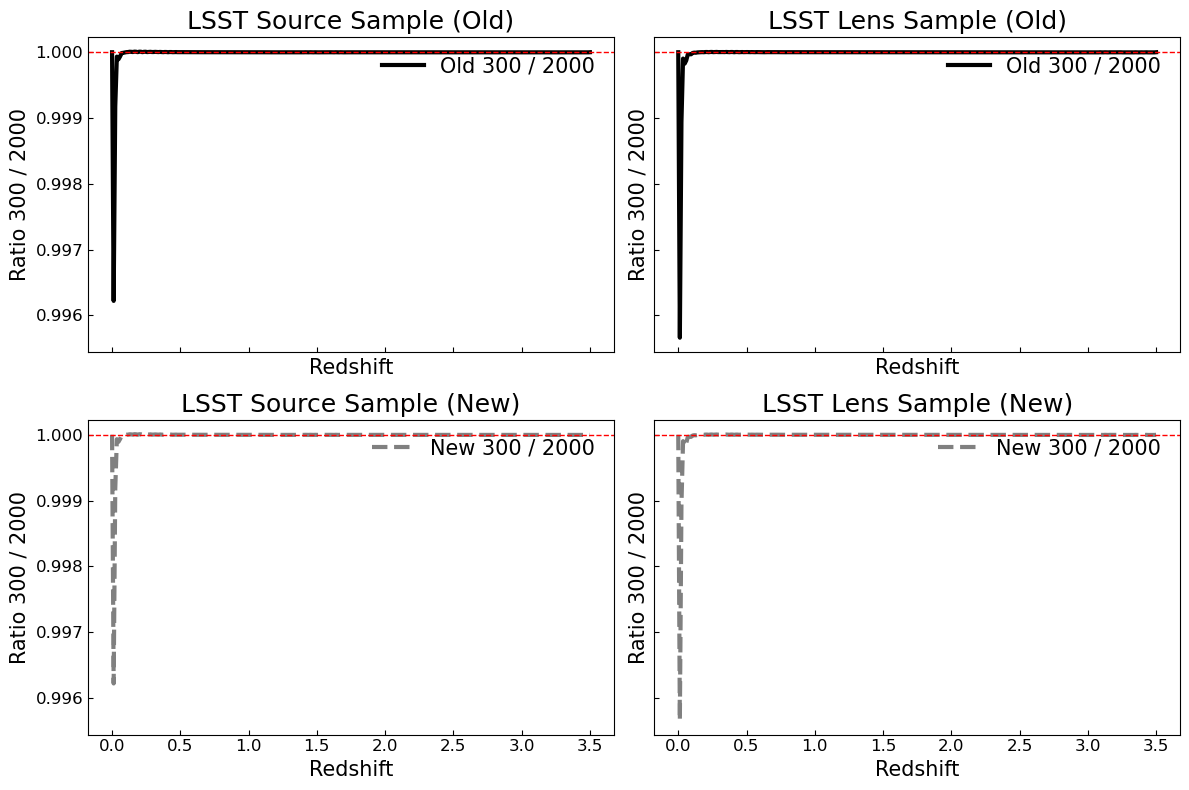

In [50]:
# Define parameters for comparison
year = "1"  # Change to "10" if needed
norm_key = "normalized"
num_z_values = [300, 2000]  # Comparing 300 vs 2000

# Define redshift ranges
redshift_range_300 = np.linspace(0.0, 3.5, 300)
redshift_range_2000 = np.linspace(0.0, 3.5, 2000)

# Create a 2x2 subplot grid for ratio plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})

# Loop through sample types (source and lens) and old/new comparisons
for i, (method, linestyle, color) in enumerate([("old", "-", "black"), ("new", "--", "gray")]):
    for j, sample_type in enumerate(["source_sample", "lens_sample"]):
        ax = axs[i, j]

        # Interpolate 2000-bin data onto 300-bin redshift grid
        data_300 = old_data[year][norm_key][300][sample_type] if method == "old" else new_data[year][norm_key][300][sample_type]
        data_2000 = np.interp(redshift_range_300, redshift_range_2000,
                              old_data[year][norm_key][2000][sample_type] if method == "old" else new_data[year][norm_key][2000][sample_type])

        # Compute ratio safely
        ratio = np.divide(data_300, data_2000, out=np.full_like(data_300, np.nan), where=data_2000 != 0)
        ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

        # Plot ratio comparison
        ax.plot(redshift_range_300, ratio, linestyle=linestyle, lw=3, color=color, label=f"{method.capitalize()} 300 / 2000")

        ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
        ax.set_xlabel('Redshift')
        ax.set_ylabel('Ratio 300 / 2000')
        ax.set_title(f'LSST {sample_type.replace("_", " ").title()} ({method.capitalize()})')
        ax.legend(frameon=False, loc='upper right')
        ax.tick_params(direction='in')

plt.tight_layout()
plt.show()


### Y10 normalized

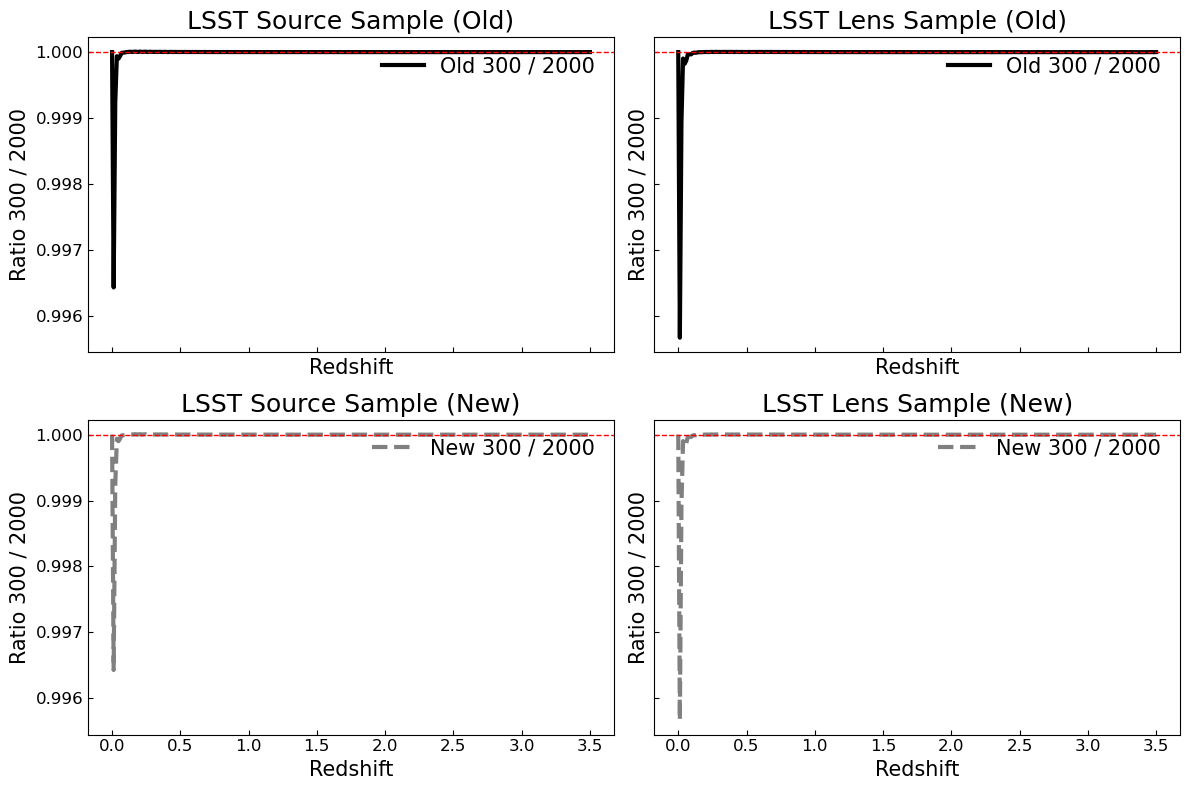

In [51]:
# Define parameters for comparison
year = "10"  # Change to "10" if needed
norm_key = "normalized"
num_z_values = [300, 2000]  # Comparing 300 vs 2000

# Define redshift ranges
redshift_range_300 = np.linspace(0.0, 3.5, 300)
redshift_range_2000 = np.linspace(0.0, 3.5, 2000)

# Create a 2x2 subplot grid for ratio plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})

# Loop through sample types (source and lens) and old/new comparisons
for i, (method, linestyle, color) in enumerate([("old", "-", "black"), ("new", "--", "gray")]):
    for j, sample_type in enumerate(["source_sample", "lens_sample"]):
        ax = axs[i, j]

        # Interpolate 2000-bin data onto 300-bin redshift grid
        data_300 = old_data[year][norm_key][300][sample_type] if method == "old" else new_data[year][norm_key][300][sample_type]
        data_2000 = np.interp(redshift_range_300, redshift_range_2000,
                              old_data[year][norm_key][2000][sample_type] if method == "old" else new_data[year][norm_key][2000][sample_type])

        # Compute ratio safely
        ratio = np.divide(data_300, data_2000, out=np.full_like(data_300, np.nan), where=data_2000 != 0)
        ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

        # Plot ratio comparison
        ax.plot(redshift_range_300, ratio, linestyle=linestyle, lw=3, color=color, label=f"{method.capitalize()} 300 / 2000")

        ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
        ax.set_xlabel('Redshift')
        ax.set_ylabel('Ratio 300 / 2000')
        ax.set_title(f'LSST {sample_type.replace("_", " ").title()} ({method.capitalize()})')
        ax.legend(frameon=False, loc='upper right')
        ax.tick_params(direction='in')

plt.tight_layout()
plt.show()


### Y1 unnormalized

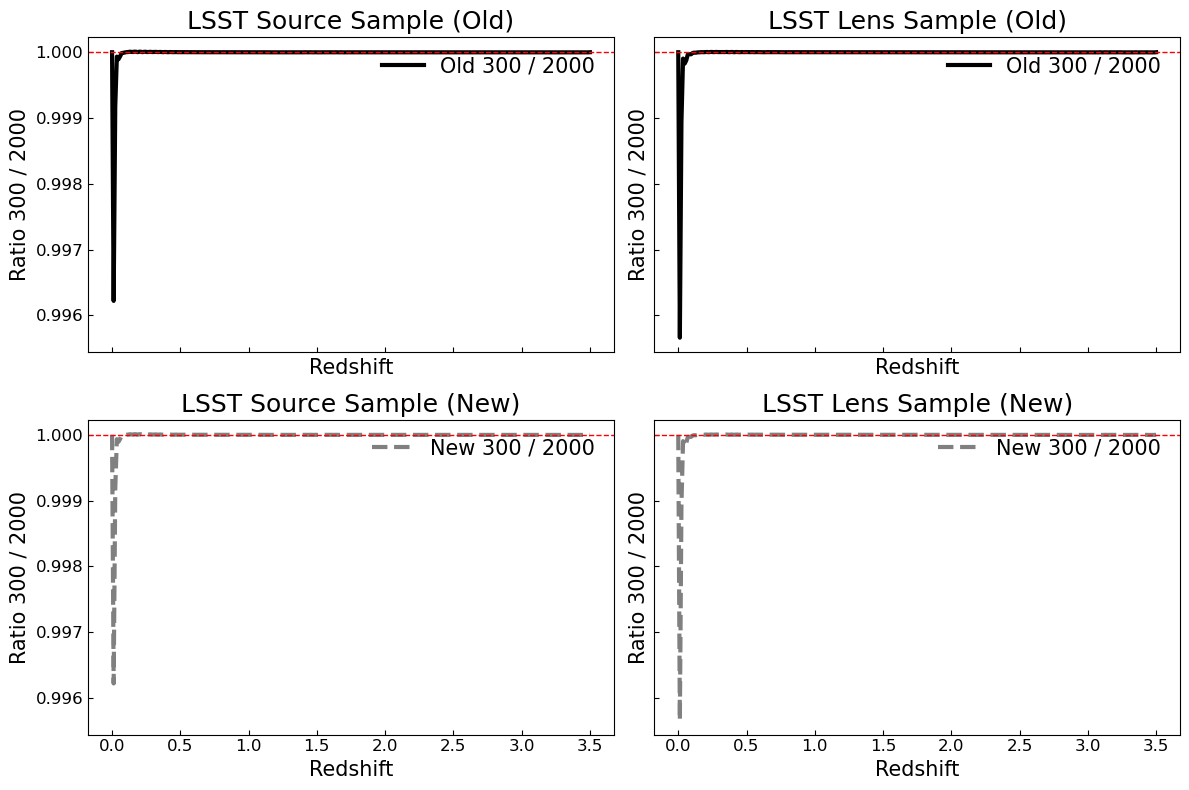

In [52]:
# Define parameters for comparison
year = "1"  # Change to "10" if needed
norm_key = "raw"
num_z_values = [300, 2000]  # Comparing 300 vs 2000

# Define redshift ranges
redshift_range_300 = np.linspace(0.0, 3.5, 300)
redshift_range_2000 = np.linspace(0.0, 3.5, 2000)

# Create a 2x2 subplot grid for ratio plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})

# Loop through sample types (source and lens) and old/new comparisons
for i, (method, linestyle, color) in enumerate([("old", "-", "black"), ("new", "--", "gray")]):
    for j, sample_type in enumerate(["source_sample", "lens_sample"]):
        ax = axs[i, j]

        # Interpolate 2000-bin data onto 300-bin redshift grid
        data_300 = old_data[year][norm_key][300][sample_type] if method == "old" else new_data[year][norm_key][300][sample_type]
        data_2000 = np.interp(redshift_range_300, redshift_range_2000,
                              old_data[year][norm_key][2000][sample_type] if method == "old" else new_data[year][norm_key][2000][sample_type])

        # Compute ratio safely
        ratio = np.divide(data_300, data_2000, out=np.full_like(data_300, np.nan), where=data_2000 != 0)
        ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

        # Plot ratio comparison
        ax.plot(redshift_range_300, ratio, linestyle=linestyle, lw=3, color=color, label=f"{method.capitalize()} 300 / 2000")

        ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
        ax.set_xlabel('Redshift')
        ax.set_ylabel('Ratio 300 / 2000')
        ax.set_title(f'LSST {sample_type.replace("_", " ").title()} ({method.capitalize()})')
        ax.legend(frameon=False, loc='upper right')
        ax.tick_params(direction='in')

plt.tight_layout()
plt.show()


### Y10 unnormalized

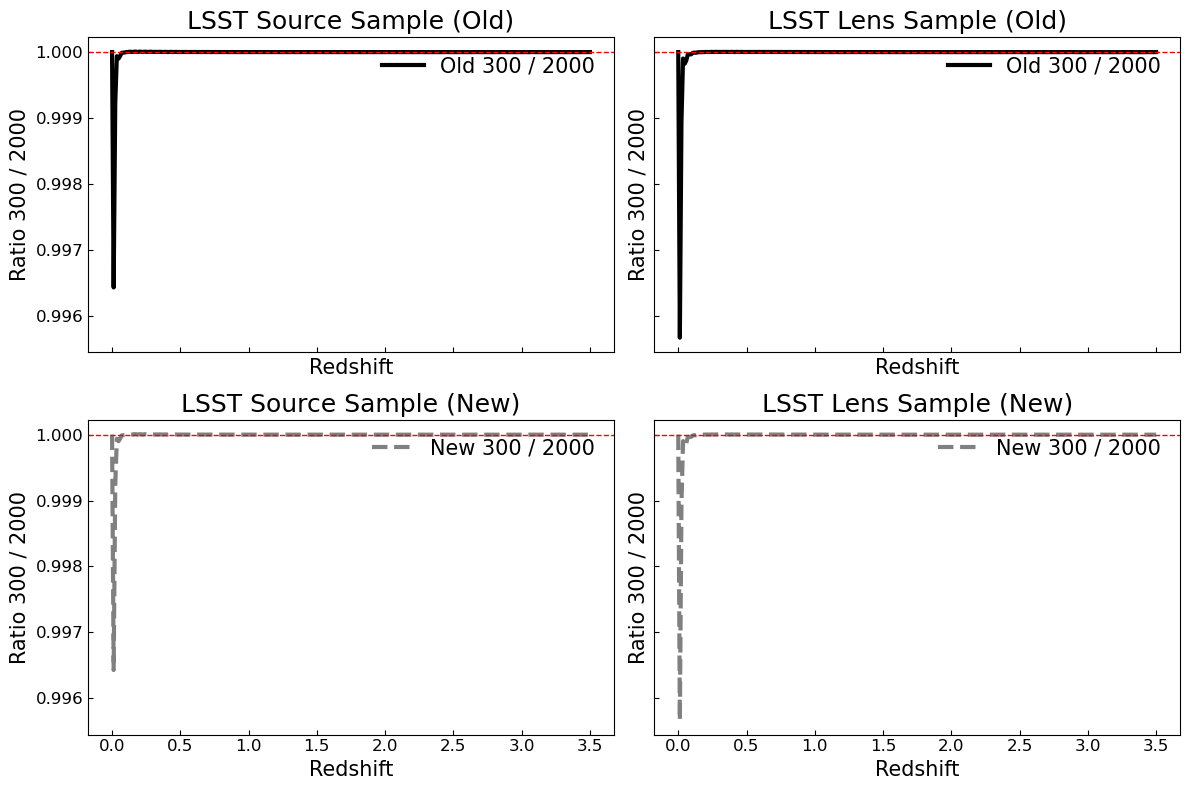

In [57]:
# Define parameters for comparison
year = "10"  # Change to "10" if needed
norm_key = "raw"
num_z_values = [300, 2000]  # Comparing 300 vs 2000

# Define redshift ranges
redshift_range_300 = np.linspace(0.0, 3.5, 300)
redshift_range_2000 = np.linspace(0.0, 3.5, 2000)

# Create a 2x2 subplot grid for ratio plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})

# Loop through sample types (source and lens) and old/new comparisons
for i, (method, linestyle, color) in enumerate([("old", "-", "black"), ("new", "--", "gray")]):
    for j, sample_type in enumerate(["source_sample", "lens_sample"]):
        ax = axs[i, j]

        # Interpolate 2000-bin data onto 300-bin redshift grid
        data_300 = old_data[year][norm_key][300][sample_type] if method == "old" else new_data[year][norm_key][300][sample_type]
        data_2000 = np.interp(redshift_range_300, redshift_range_2000,
                              old_data[year][norm_key][2000][sample_type] if method == "old" else new_data[year][norm_key][2000][sample_type])

        # Compute ratio safely
        ratio = np.divide(data_300, data_2000, out=np.full_like(data_300, np.nan), where=data_2000 != 0)
        ratio = np.nan_to_num(ratio, nan=1.0, posinf=1.0, neginf=1.0)

        # Plot ratio comparison
        ax.plot(redshift_range_300, ratio, linestyle=linestyle, lw=3, color=color, label=f"{method.capitalize()} 300 / 2000")

        ax.axhline(1.0, linestyle='--', color='red', lw=1)  # Reference line at 1
        ax.set_xlabel('Redshift')
        ax.set_ylabel('Ratio 300 / 2000')
        ax.set_title(f'LSST {sample_type.replace("_", " ").title()} ({method.capitalize()})')
        ax.legend(frameon=False, loc='upper right')
        ax.tick_params(direction='in')

plt.tight_layout()
plt.show()


# Plot the LSST tomo bins

## Lens bins for Year 1 and Year 10, normalized, 300 redshift points

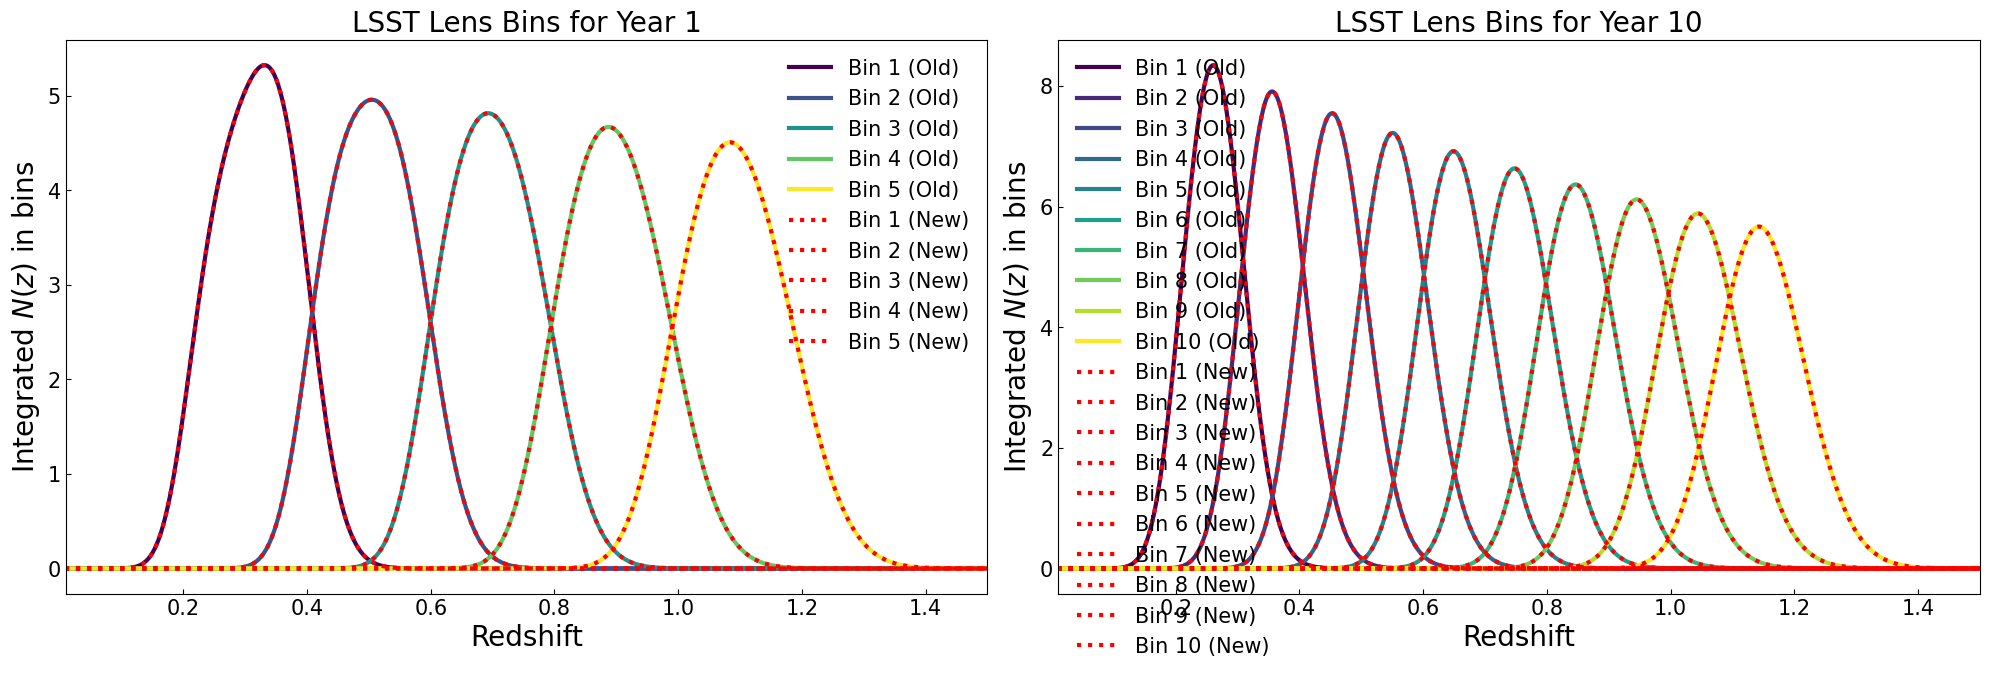

In [64]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"
num_z = 2000  # Number of redshift points
redshift_range = np.linspace(0.0, 3.5, num_z)

# Create subplots for Year 1 and Year 10
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]

    # Get the number of bins (assuming all bins have the same count)
    num_bins = len(old_data[year][norm_key][num_z]["lens_bins"])

    # Generate colors dynamically using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, num_bins))

    # Old method: solid lines
    for bin_idx, (key, data) in enumerate(old_data[year][norm_key][num_z]["lens_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (Old)",
                color=colors[bin_idx],
                linestyle='-')

    # New method: dotted lines (overlay on top)
    for bin_idx, (key, data) in enumerate(new_data[year][norm_key][num_z]["lens_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (New)",
                color="red",
                linestyle=':')

    # Labels, titles, and styling
    ax.set_xlim(0.01, 1.5)
    ax.set_xlabel("Redshift", fontsize=20)
    ax.set_ylabel("Integrated $N(z)$ in bins", fontsize=20)
    ax.set_title(f"LSST Lens Bins for Year {year}", fontsize=20)
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major', labelsize=15)

# Show the plot
plt.tight_layout()
plt.show()


## Lens bins for Year 1 and Year 10, normalized, 2000 redshift points

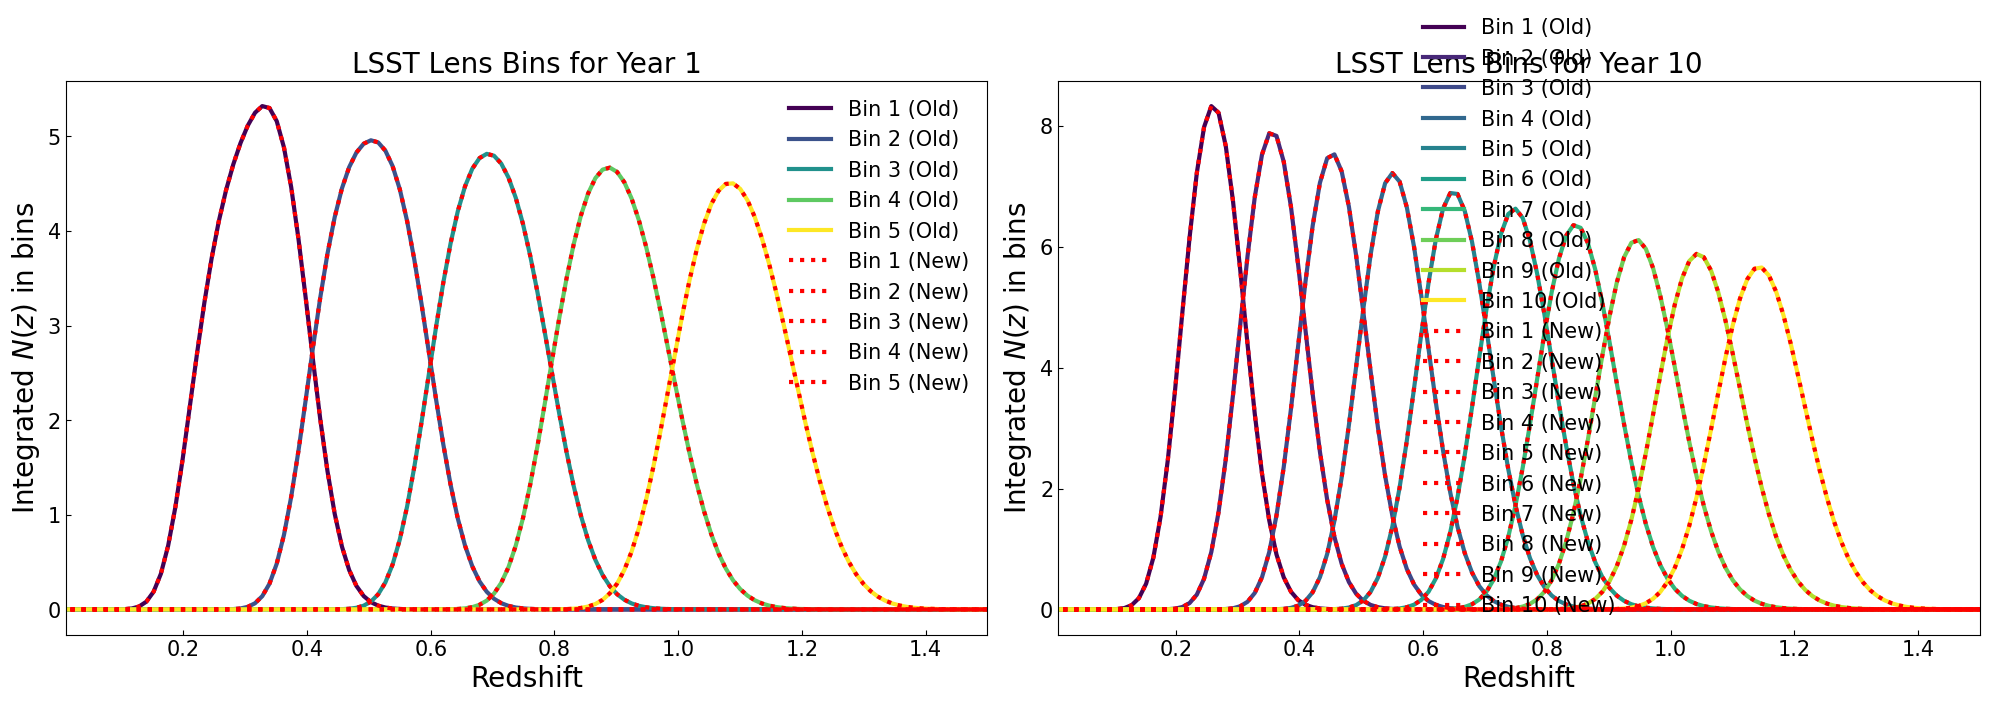

In [65]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"
num_z = 300  # Number of redshift points
redshift_range = np.linspace(0.0, 3.5, num_z)

# Create subplots for Year 1 and Year 10
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]

    # Get the number of bins (assuming all bins have the same count)
    num_bins = len(old_data[year][norm_key][num_z]["lens_bins"])

    # Generate colors dynamically using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, num_bins))

    # Old method: solid lines
    for bin_idx, (key, data) in enumerate(old_data[year][norm_key][num_z]["lens_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (Old)",
                color=colors[bin_idx],
                linestyle='-')

    # New method: dotted lines (overlay on top)
    for bin_idx, (key, data) in enumerate(new_data[year][norm_key][num_z]["lens_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (New)",
                color="red",
                linestyle=':')

    # Labels, titles, and styling
    ax.set_xlim(0.01, 1.5)
    ax.set_xlabel("Redshift", fontsize=20)
    ax.set_ylabel("Integrated $N(z)$ in bins", fontsize=20)
    ax.set_title(f"LSST Lens Bins for Year {year}", fontsize=20)
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major', labelsize=15)

# Show the plot
plt.tight_layout()
plt.show()


## Lens bins for Year 1 and Year 10, unnormalized, 300 redshift points

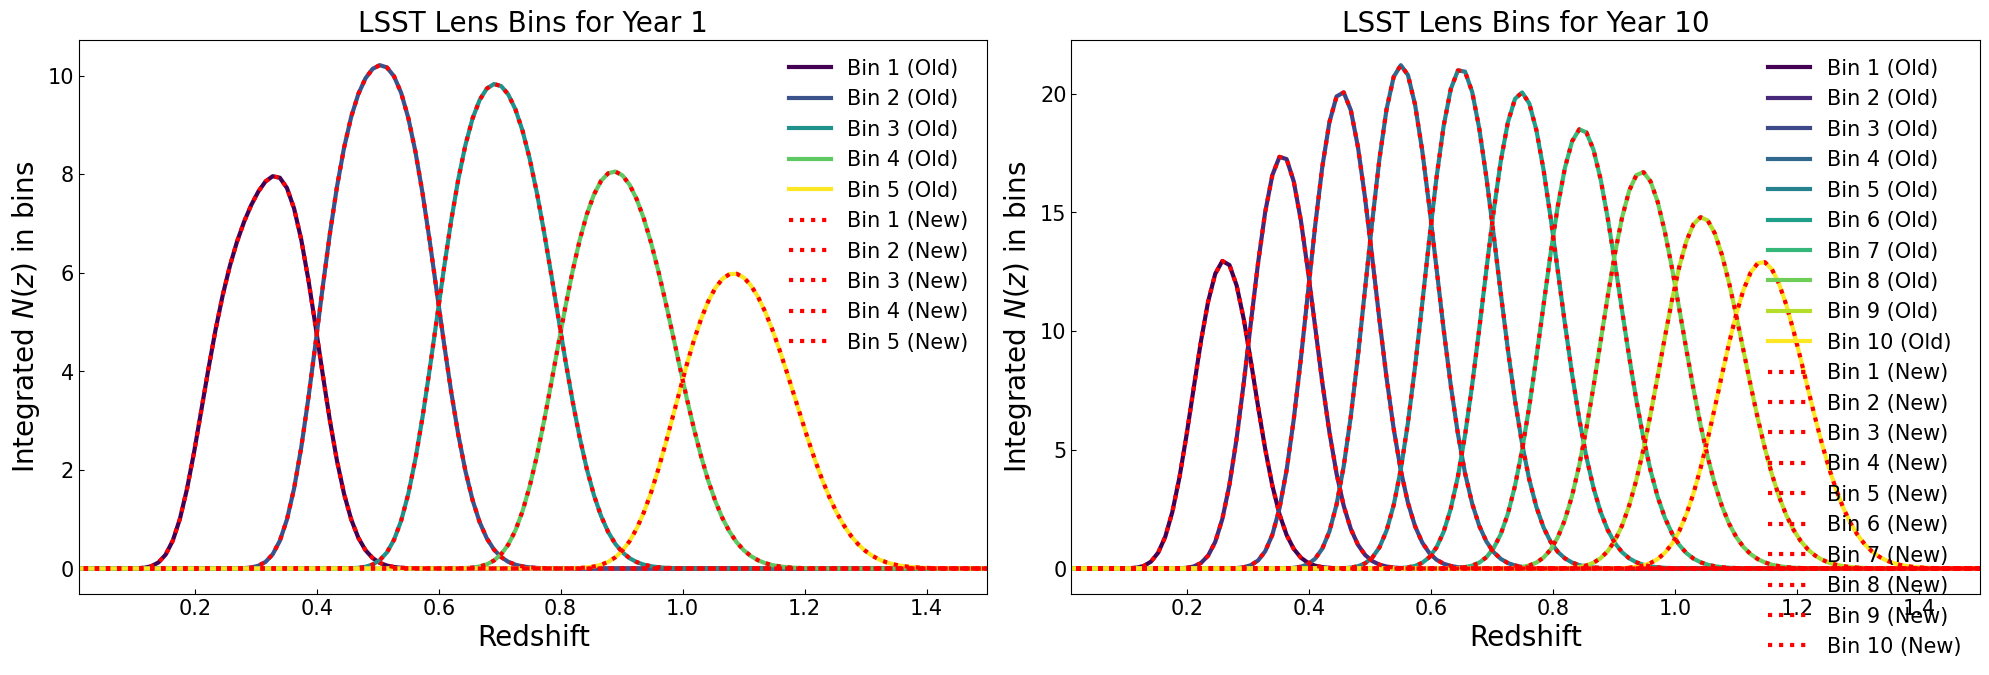

In [67]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z = 300  # Number of redshift points
redshift_range = np.linspace(0.0, 3.5, num_z)

# Create subplots for Year 1 and Year 10
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]

    # Get the number of bins (assuming all bins have the same count)
    num_bins = len(old_data[year][norm_key][num_z]["lens_bins"])

    # Generate colors dynamically using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, num_bins))

    # Old method: solid lines
    for bin_idx, (key, data) in enumerate(old_data[year][norm_key][num_z]["lens_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (Old)",
                color=colors[bin_idx],
                linestyle='-')

    # New method: dotted lines (overlay on top)
    for bin_idx, (key, data) in enumerate(new_data[year][norm_key][num_z]["lens_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (New)",
                color="red",
                linestyle=':')

    # Labels, titles, and styling
    ax.set_xlim(0.01, 1.5)
    ax.set_xlabel("Redshift", fontsize=20)
    ax.set_ylabel("Integrated $N(z)$ in bins", fontsize=20)
    ax.set_title(f"LSST Lens Bins for Year {year}", fontsize=20)
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major', labelsize=15)

# Show the plot
plt.tight_layout()
plt.show()


## Lens bins for Year 1 and Year 10, unnormalized, 2000 redshift points

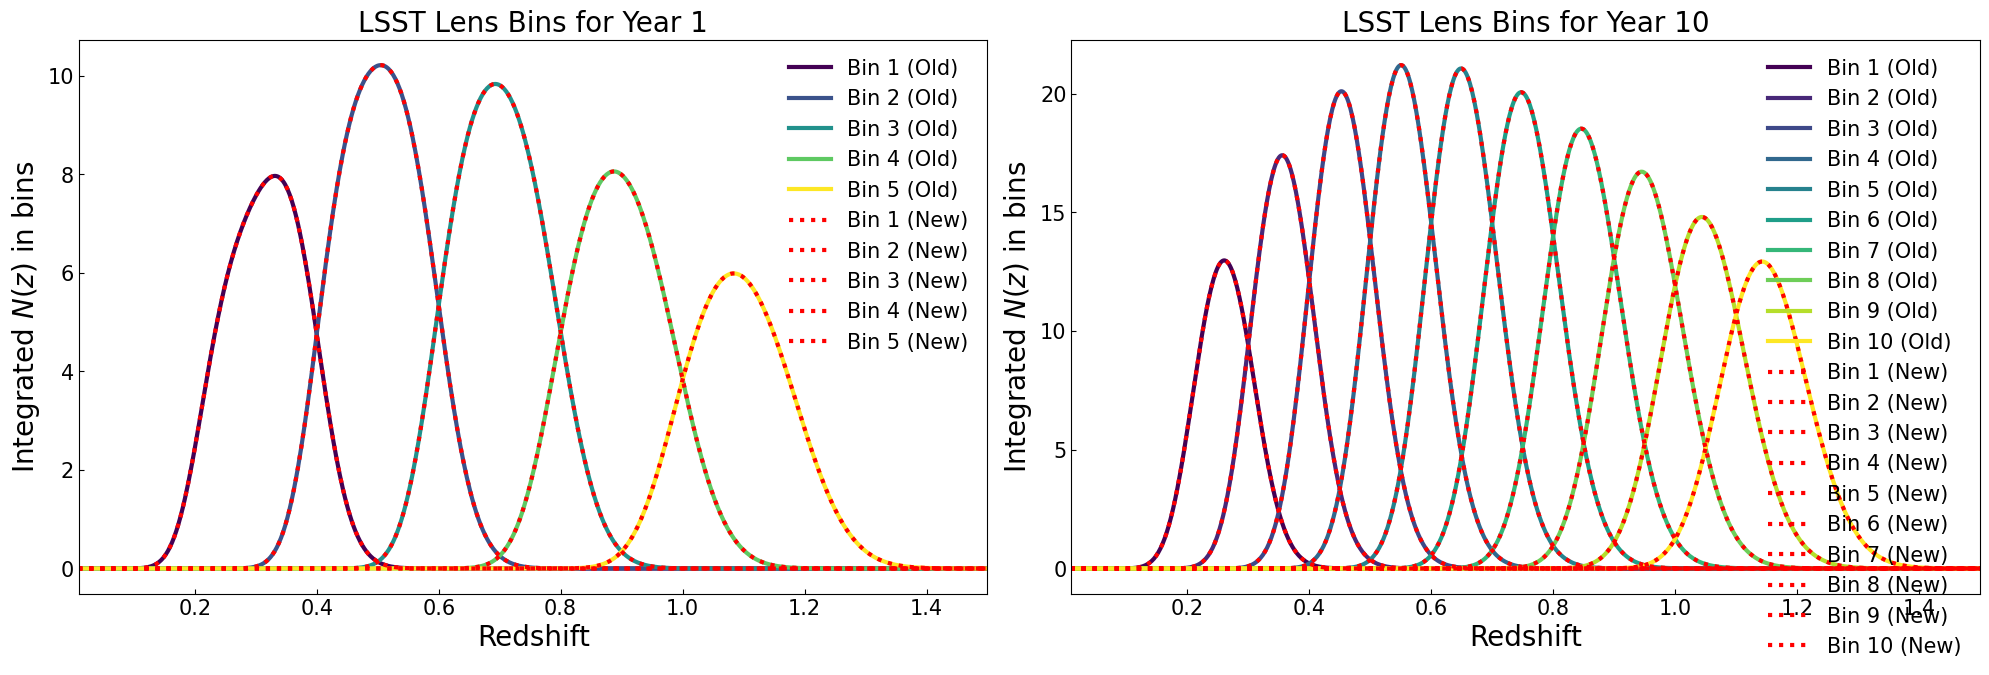

In [68]:
# Prelims
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z = 2000  # Number of redshift points
redshift_range = np.linspace(0.0, 3.5, num_z)

# Create subplots for Year 1 and Year 10
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]

    # Get the number of bins (assuming all bins have the same count)
    num_bins = len(old_data[year][norm_key][num_z]["lens_bins"])

    # Generate colors dynamically using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, num_bins))

    # Old method: solid lines
    for bin_idx, (key, data) in enumerate(old_data[year][norm_key][num_z]["lens_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (Old)",
                color=colors[bin_idx],
                linestyle='-')

    # New method: dotted lines (overlay on top)
    for bin_idx, (key, data) in enumerate(new_data[year][norm_key][num_z]["lens_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (New)",
                color="red",
                linestyle=':')

    # Labels, titles, and styling
    ax.set_xlim(0.01, 1.5)
    ax.set_xlabel("Redshift", fontsize=20)
    ax.set_ylabel("Integrated $N(z)$ in bins", fontsize=20)
    ax.set_title(f"LSST Lens Bins for Year {year}", fontsize=20)
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major', labelsize=15)

# Show the plot
plt.tight_layout()
plt.show()


## Source bins for Year 1 and Year 10, normalized, 300 redshift points

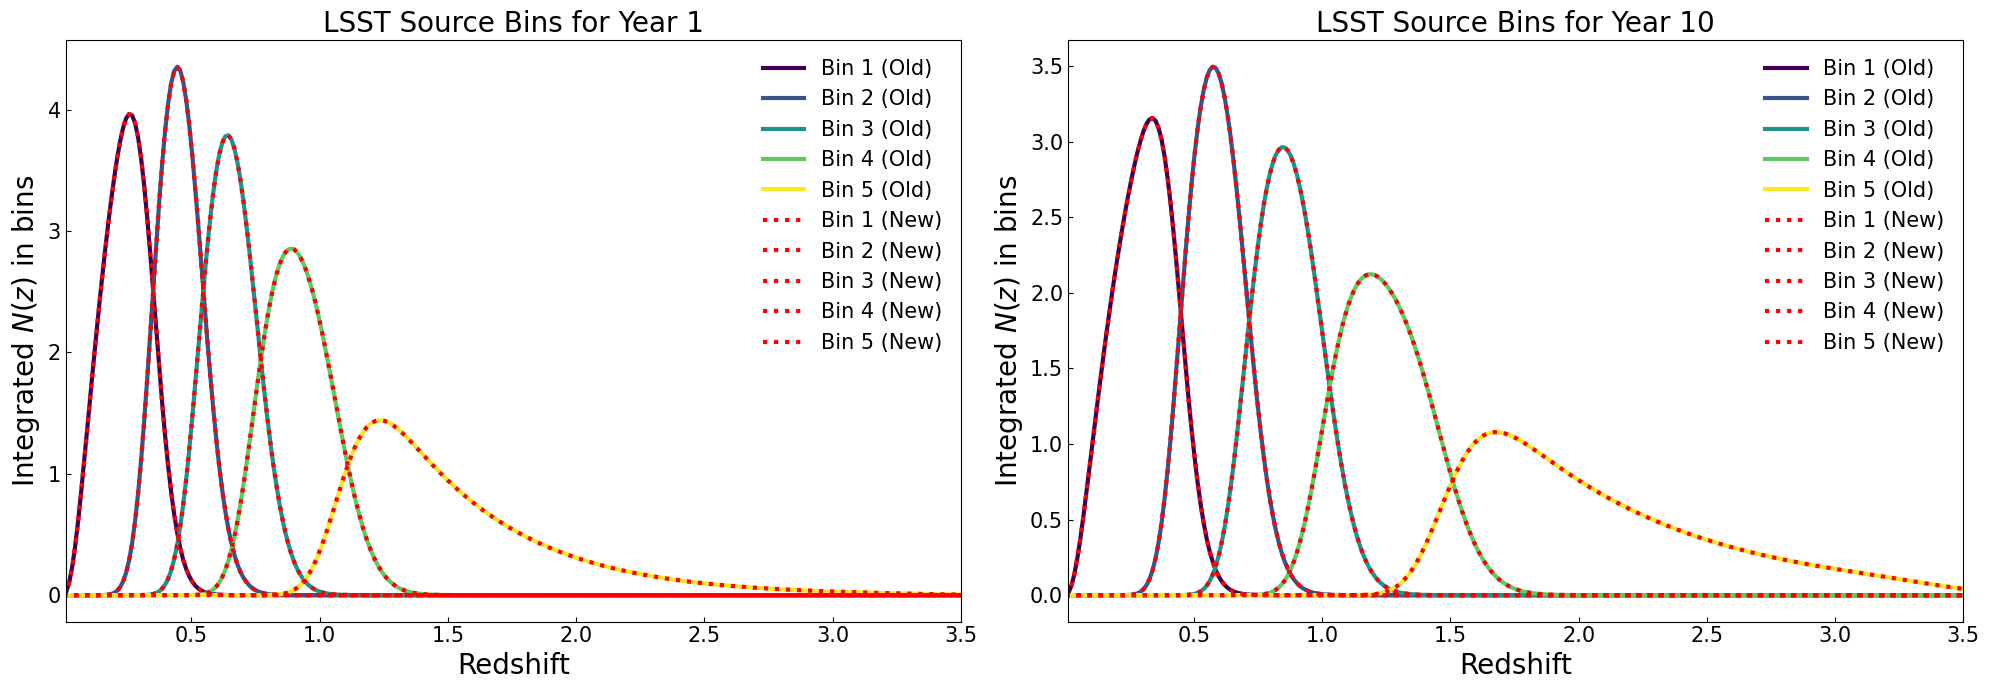

In [69]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"
num_z = 300  # Number of redshift points
redshift_range = np.linspace(0.0, 3.5, num_z)

# Create subplots for Year 1 and Year 10 (source bins)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]

    # Get the number of bins (assuming all bins have the same count)
    num_bins = len(old_data[year][norm_key][num_z]["source_bins"])

    # Generate colors dynamically using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, num_bins))

    # Old method: solid lines
    for bin_idx, (key, data) in enumerate(old_data[year][norm_key][num_z]["source_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (Old)",
                color=colors[bin_idx],
                linestyle='-')

    # New method: dotted lines (overlay on top)
    for bin_idx, (key, data) in enumerate(new_data[year][norm_key][num_z]["source_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (New)",
                color="red",
                linestyle=':')

    # Labels, titles, and styling
    ax.set_xlim(0.01, 3.5)  # Adjust x-axis range
    ax.set_xlabel("Redshift", fontsize=20)
    ax.set_ylabel("Integrated $N(z)$ in bins", fontsize=20)
    ax.set_title(f"LSST Source Bins for Year {year}", fontsize=20)
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major', labelsize=15)

# Show the plot
plt.tight_layout()
plt.show()


## Source bins for Year 1 and Year 10, normalized, 2000 redshift points

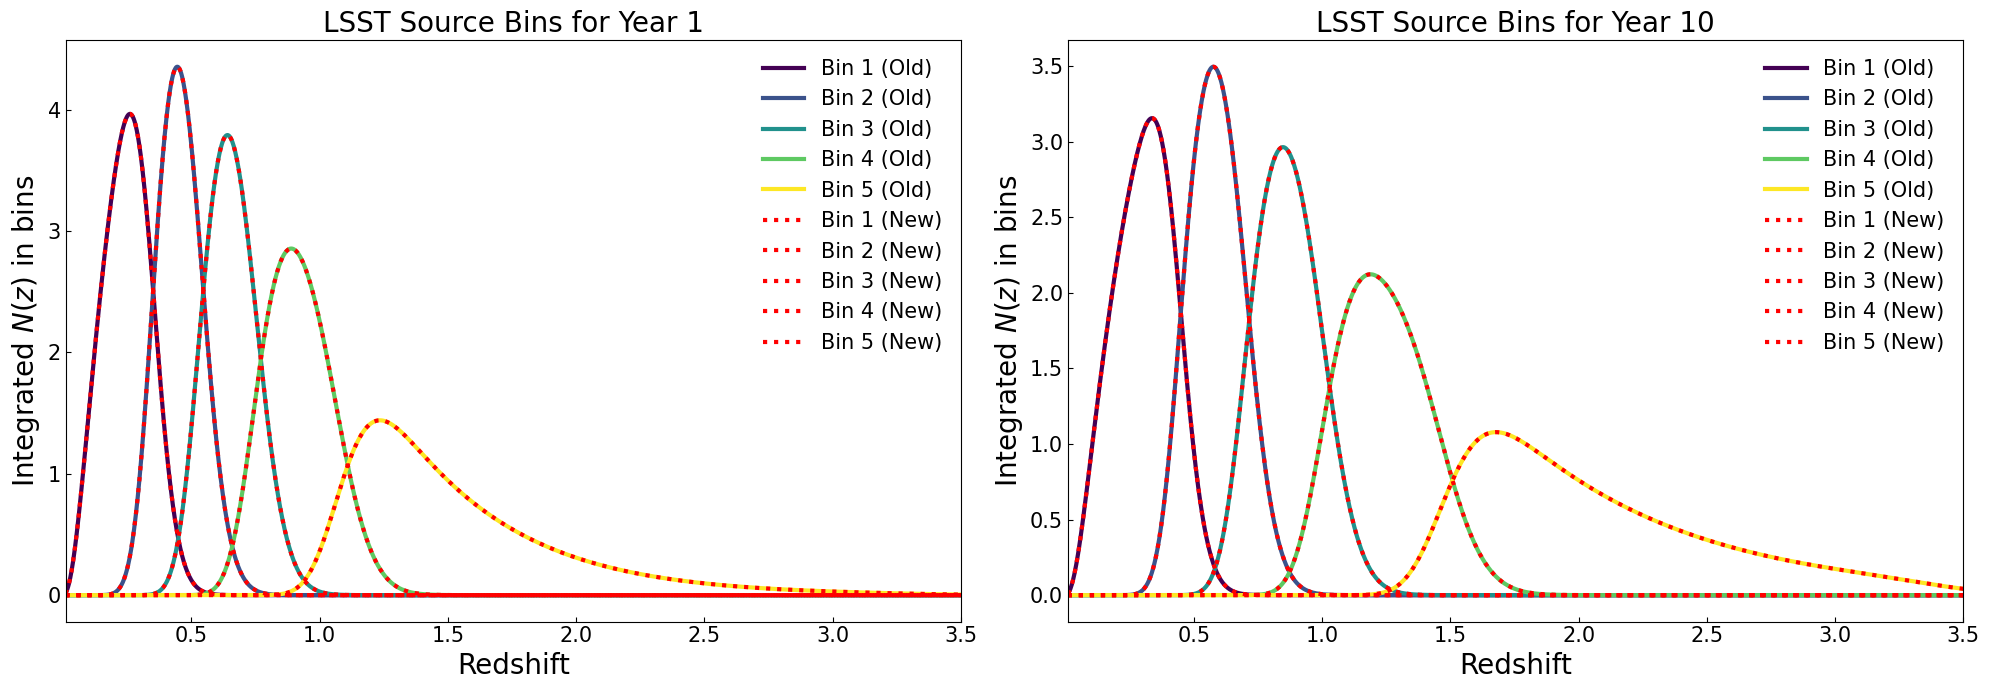

In [70]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"
num_z = 2000  # Number of redshift points
redshift_range = np.linspace(0.0, 3.5, num_z)

# Create subplots for Year 1 and Year 10 (source bins)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]

    # Get the number of bins (assuming all bins have the same count)
    num_bins = len(old_data[year][norm_key][num_z]["source_bins"])

    # Generate colors dynamically using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, num_bins))

    # Old method: solid lines
    for bin_idx, (key, data) in enumerate(old_data[year][norm_key][num_z]["source_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (Old)",
                color=colors[bin_idx],
                linestyle='-')

    # New method: dotted lines (overlay on top)
    for bin_idx, (key, data) in enumerate(new_data[year][norm_key][num_z]["source_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (New)",
                color="red",
                linestyle=':')

    # Labels, titles, and styling
    ax.set_xlim(0.01, 3.5)  # Adjust x-axis range
    ax.set_xlabel("Redshift", fontsize=20)
    ax.set_ylabel("Integrated $N(z)$ in bins", fontsize=20)
    ax.set_title(f"LSST Source Bins for Year {year}", fontsize=20)
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major', labelsize=15)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
## Source bins for Year 1 and Year 10, unnormalized, 300 redshift points

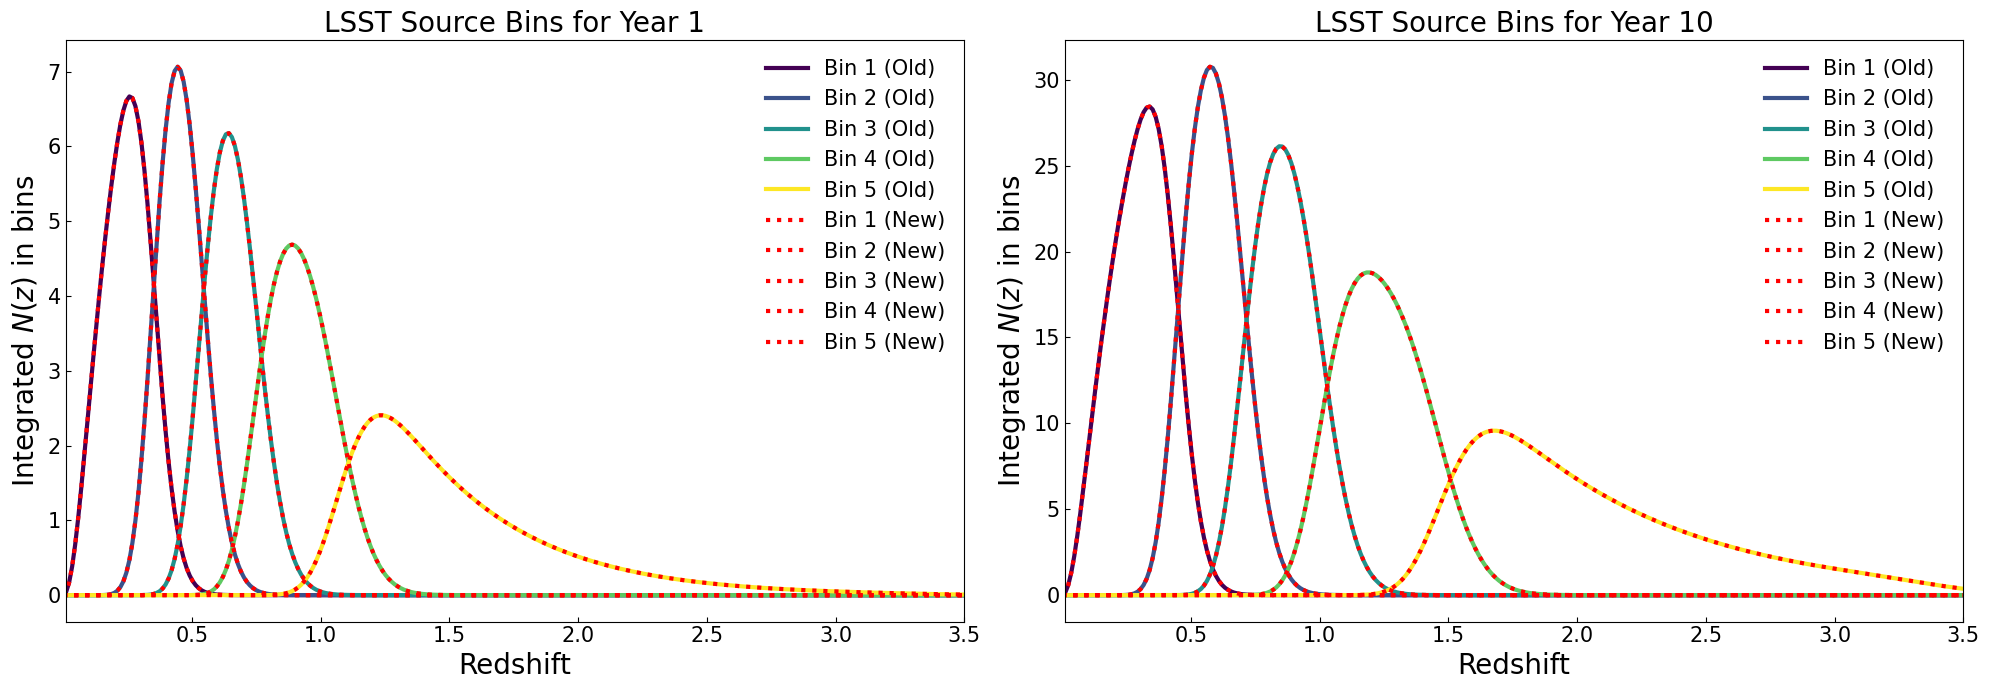

In [71]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z = 300  # Number of redshift points
redshift_range = np.linspace(0.0, 3.5, num_z)

# Create subplots for Year 1 and Year 10 (source bins)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]

    # Get the number of bins (assuming all bins have the same count)
    num_bins = len(old_data[year][norm_key][num_z]["source_bins"])

    # Generate colors dynamically using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, num_bins))

    # Old method: solid lines
    for bin_idx, (key, data) in enumerate(old_data[year][norm_key][num_z]["source_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (Old)",
                color=colors[bin_idx],
                linestyle='-')

    # New method: dotted lines (overlay on top)
    for bin_idx, (key, data) in enumerate(new_data[year][norm_key][num_z]["source_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (New)",
                color="red",
                linestyle=':')

    # Labels, titles, and styling
    ax.set_xlim(0.01, 3.5)  # Adjust x-axis range
    ax.set_xlabel("Redshift", fontsize=20)
    ax.set_ylabel("Integrated $N(z)$ in bins", fontsize=20)
    ax.set_title(f"LSST Source Bins for Year {year}", fontsize=20)
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major', labelsize=15)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
## Source bins for Year 1 and Year 10, unnormalized, 2000 redshift points

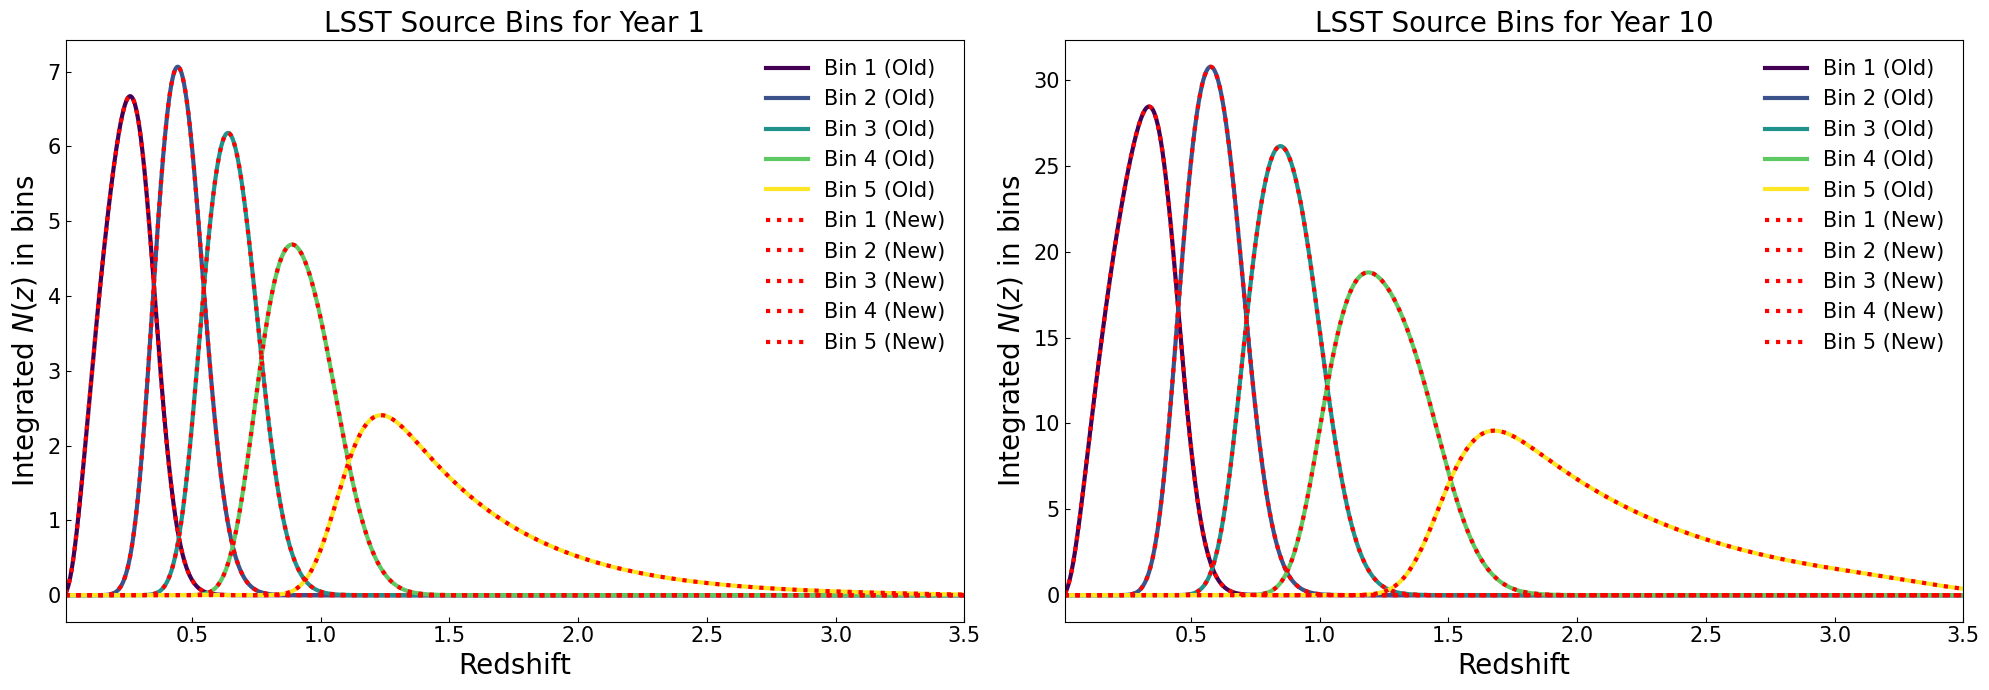

In [73]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z = 2000  # Number of redshift points
redshift_range = np.linspace(0.0, 3.5, num_z)

# Create subplots for Year 1 and Year 10 (source bins)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for idx, year in enumerate(years):
    ax = axes[idx]

    # Get the number of bins (assuming all bins have the same count)
    num_bins = len(old_data[year][norm_key][num_z]["source_bins"])

    # Generate colors dynamically using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, num_bins))

    # Old method: solid lines
    for bin_idx, (key, data) in enumerate(old_data[year][norm_key][num_z]["source_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (Old)",
                color=colors[bin_idx],
                linestyle='-')

    # New method: dotted lines (overlay on top)
    for bin_idx, (key, data) in enumerate(new_data[year][norm_key][num_z]["source_bins"].items()):
        ax.plot(redshift_range,
                data,
                label=f"Bin {key+1} (New)",
                color="red",
                linestyle=':')

    # Labels, titles, and styling
    ax.set_xlim(0.01, 3.5)  # Adjust x-axis range
    ax.set_xlabel("Redshift", fontsize=20)
    ax.set_ylabel("Integrated $N(z)$ in bins", fontsize=20)
    ax.set_title(f"LSST Source Bins for Year {year}", fontsize=20)
    ax.tick_params(direction='in')
    ax.legend(frameon=False, ncol=1)
    ax.tick_params(axis='both', which='major', labelsize=15)

# Show the plot
plt.tight_layout()
plt.show()


# Compare bin centers for old and new methods

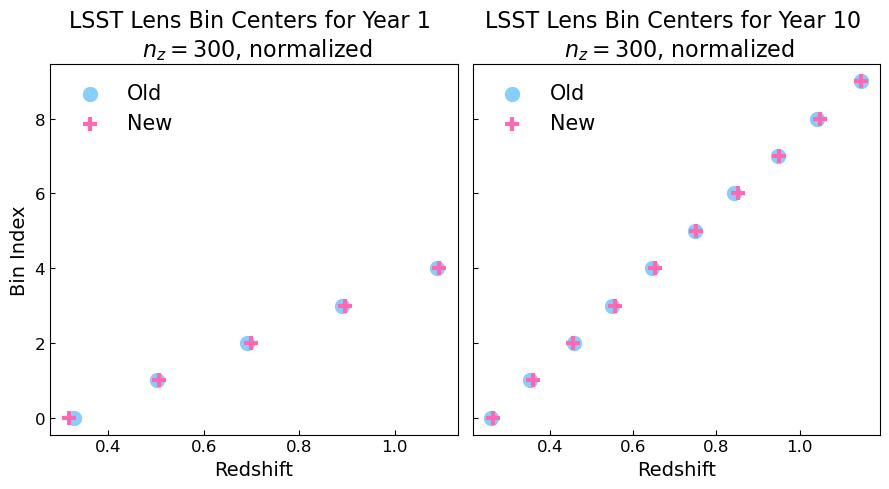

In [95]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"
num_z = 300  # Number of redshift points

# Create subplots for Year 1 and Year 10 (lens bin centers)
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)

for idx, year in enumerate(years):
    ax = axes[idx]

    # Extract old bin centers (directly from "lenses" key)
    old_centers = np.array(old_data[year][norm_key][num_z]["lens_bin_centers"]["lenses"])

    # Extract new bin centers (sorted by index)
    new_centers = np.array([new_data[year][norm_key][num_z]["lens_bin_centers"][k] for k in sorted(new_data[year][norm_key][num_z]["lens_bin_centers"].keys())])

    # Scatter plot for bin centers
    ax.scatter(old_centers, np.arange(len(old_centers)), label="Old", marker='o', color='lightskyblue', s=100)
    ax.scatter(new_centers, np.arange(len(new_centers)), label="New", marker='+', color='hotpink', s=100)

    # Labels, titles, and styling
    ax.set_xlabel("Redshift", fontsize=14)
    ax.set_title(f"LSST Lens Bin Centers for Year {year} \n $n_z = {num_z}$, {norm_key}", fontsize=16)
    ax.tick_params(direction='in', labelsize=12)
    ax.legend(frameon=False, loc='upper left')

axes[0].set_ylabel("Bin Index", fontsize=14)  # Only left plot gets the y-label

plt.tight_layout()
plt.show()


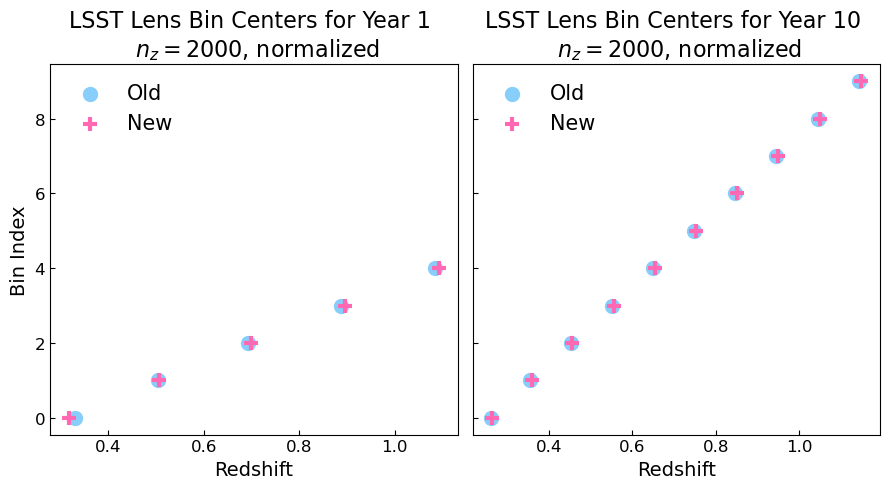

In [96]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"
num_z = 2000  # Number of redshift points

# Create subplots for Year 1 and Year 10 (lens bin centers)
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)

for idx, year in enumerate(years):
    ax = axes[idx]

    # Extract old bin centers (directly from "lenses" key)
    old_centers = np.array(old_data[year][norm_key][num_z]["lens_bin_centers"]["lenses"])

    # Extract new bin centers (sorted by index)
    new_centers = np.array([new_data[year][norm_key][num_z]["lens_bin_centers"][k] for k in sorted(new_data[year][norm_key][num_z]["lens_bin_centers"].keys())])

    # Scatter plot for bin centers
    ax.scatter(old_centers, np.arange(len(old_centers)), label="Old", marker='o', color='lightskyblue', s=100)
    ax.scatter(new_centers, np.arange(len(new_centers)), label="New", marker='+', color='hotpink', s=100)

    # Labels, titles, and styling
    ax.set_xlabel("Redshift", fontsize=14)
    ax.set_title(f"LSST Lens Bin Centers for Year {year} \n $n_z = {num_z}$, {norm_key}", fontsize=16)
    ax.tick_params(direction='in', labelsize=12)
    ax.legend(frameon=False, loc='upper left')

axes[0].set_ylabel("Bin Index", fontsize=14)  # Only left plot gets the y-label

plt.tight_layout()
plt.show()


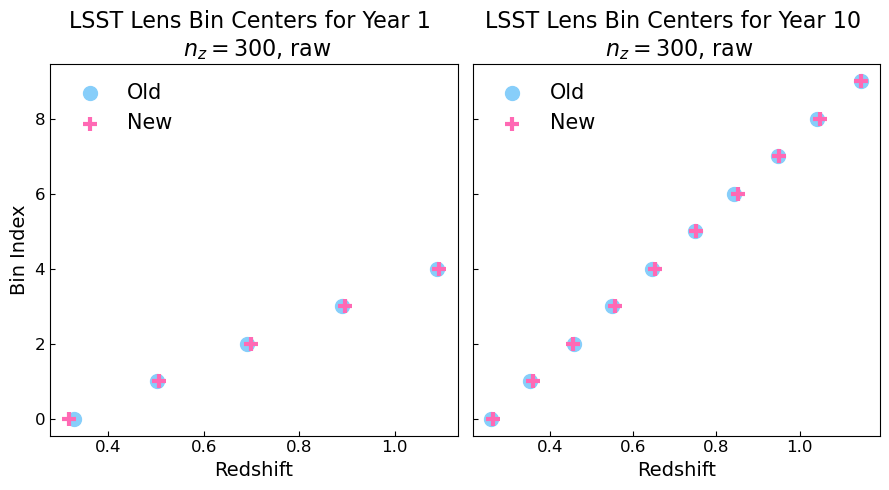

In [97]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z = 300  # Number of redshift points

# Create subplots for Year 1 and Year 10 (lens bin centers)
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)

for idx, year in enumerate(years):
    ax = axes[idx]

    # Extract old bin centers (directly from "lenses" key)
    old_centers = np.array(old_data[year][norm_key][num_z]["lens_bin_centers"]["lenses"])

    # Extract new bin centers (sorted by index)
    new_centers = np.array([new_data[year][norm_key][num_z]["lens_bin_centers"][k] for k in sorted(new_data[year][norm_key][num_z]["lens_bin_centers"].keys())])

    # Scatter plot for bin centers
    ax.scatter(old_centers, np.arange(len(old_centers)), label="Old", marker='o', color='lightskyblue', s=100)
    ax.scatter(new_centers, np.arange(len(new_centers)), label="New", marker='+', color='hotpink', s=100)

    # Labels, titles, and styling
    ax.set_xlabel("Redshift", fontsize=14)
    ax.set_title(f"LSST Lens Bin Centers for Year {year} \n $n_z = {num_z}$, {norm_key}", fontsize=16)
    ax.tick_params(direction='in', labelsize=12)
    ax.legend(frameon=False, loc='upper left')

axes[0].set_ylabel("Bin Index", fontsize=14)  # Only left plot gets the y-label

plt.tight_layout()
plt.show()


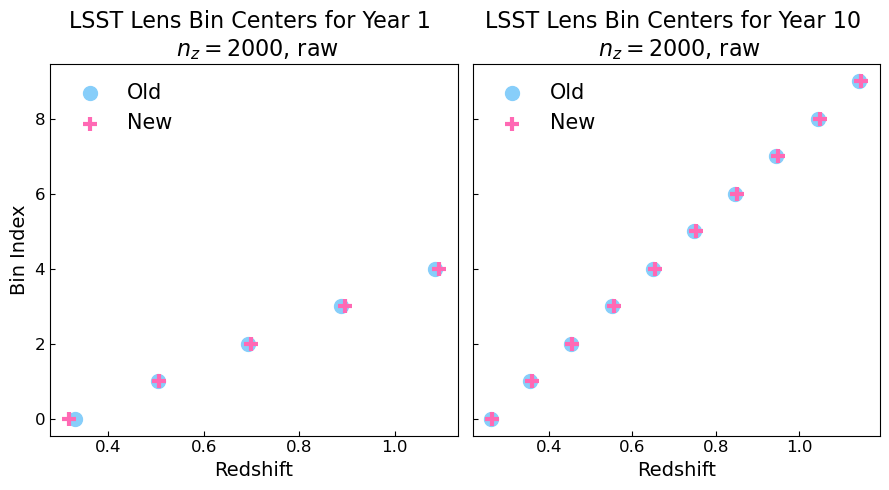

In [98]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z = 2000  # Number of redshift points

# Create subplots for Year 1 and Year 10 (lens bin centers)
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)

for idx, year in enumerate(years):
    ax = axes[idx]

    # Extract old bin centers (directly from "lenses" key)
    old_centers = np.array(old_data[year][norm_key][num_z]["lens_bin_centers"]["lenses"])

    # Extract new bin centers (sorted by index)
    new_centers = np.array([new_data[year][norm_key][num_z]["lens_bin_centers"][k] for k in sorted(new_data[year][norm_key][num_z]["lens_bin_centers"].keys())])

    # Scatter plot for bin centers
    ax.scatter(old_centers, np.arange(len(old_centers)), label="Old", marker='o', color='lightskyblue', s=100)
    ax.scatter(new_centers, np.arange(len(new_centers)), label="New", marker='+', color='hotpink', s=100)

    # Labels, titles, and styling
    ax.set_xlabel("Redshift", fontsize=14)
    ax.set_title(f"LSST Lens Bin Centers for Year {year} \n $n_z = {num_z}$, {norm_key}", fontsize=16)
    ax.tick_params(direction='in', labelsize=12)
    ax.legend(frameon=False, loc='upper left')

axes[0].set_ylabel("Bin Index", fontsize=14)  # Only left plot gets the y-label

plt.tight_layout()
plt.show()


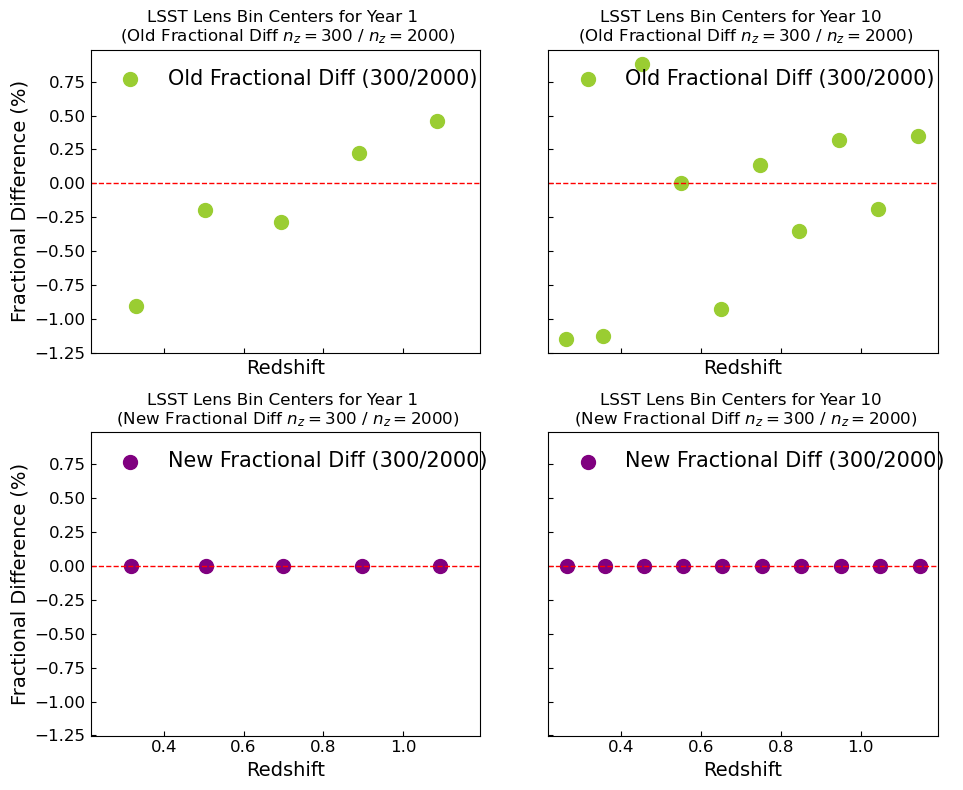

In [105]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"
num_z_300, num_z_2000 = 300, 2000  # Bin resolutions to compare

# Define colors for fractional difference
colors = {"old": "yellowgreen", "new": "purple"}

# Create 2x2 subplots: Top row (old fractional diff), Bottom row (new fractional diff)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for row_idx, method in enumerate(["old", "new"]):  # Old = row 0, New = row 1
    for col_idx, year in enumerate(years):  # Year 1 = col 0, Year 10 = col 1
        ax = axes[row_idx, col_idx]

        # Extract bin centers
        if method == "old":
            centers_300 = np.array(old_data[year][norm_key][num_z_300]["lens_bin_centers"]["lenses"])
            centers_2000 = np.array(old_data[year][norm_key][num_z_2000]["lens_bin_centers"]["lenses"])
        else:
            centers_300 = np.array([new_data[year][norm_key][num_z_300]["lens_bin_centers"][k]
                                    for k in sorted(new_data[year][norm_key][num_z_300]["lens_bin_centers"].keys())])
            centers_2000 = np.array([new_data[year][norm_key][num_z_2000]["lens_bin_centers"][k]
                                    for k in sorted(new_data[year][norm_key][num_z_2000]["lens_bin_centers"].keys())])

        # Compute fractional difference safely
        frac_diff = 100 * np.divide((centers_300 - centers_2000), centers_2000,
                                    out=np.full_like(centers_300, np.nan),
                                    where=centers_2000 != 0)  # Convert to percentage

        # Scatter plot for fractional difference
        ax.scatter(centers_2000, frac_diff, color=colors[method], s=100,
                   label=f"{method.capitalize()} Fractional Diff (300/2000)")

        # Reference line at fractional difference = 0
        ax.axhline(0.0, linestyle="--", color="red", lw=1)

        # Labels, titles, and styling
        ax.set_xlabel("Redshift", fontsize=14)
        if col_idx == 0:
            ax.set_ylabel("Fractional Difference (%)", fontsize=14)

        ax.set_title(f"LSST Lens Bin Centers for Year {year} \n ({method.capitalize()} Fractional Diff $n_z = 300$ / $n_z = 2000$)", fontsize=12)
        ax.tick_params(direction="in", labelsize=12)
        ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.show()


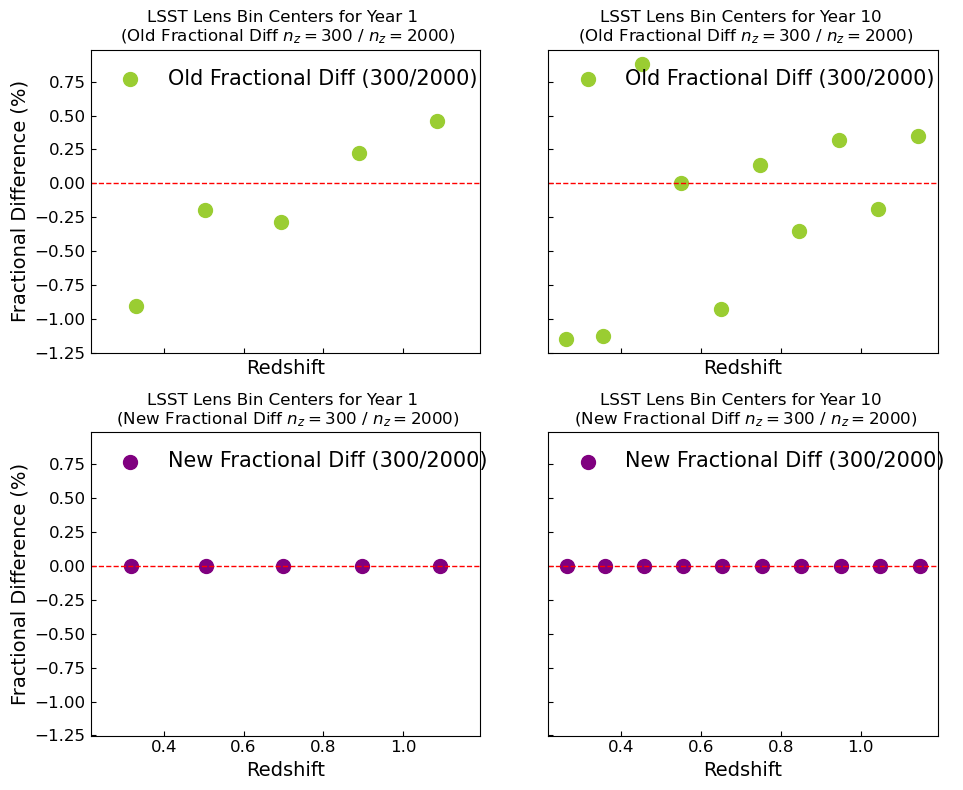

In [106]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z_300, num_z_2000 = 300, 2000  # Bin resolutions to compare

# Define colors for fractional difference
colors = {"old": "yellowgreen", "new": "purple"}

# Create 2x2 subplots: Top row (old fractional diff), Bottom row (new fractional diff)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for row_idx, method in enumerate(["old", "new"]):  # Old = row 0, New = row 1
    for col_idx, year in enumerate(years):  # Year 1 = col 0, Year 10 = col 1
        ax = axes[row_idx, col_idx]

        # Extract bin centers
        if method == "old":
            centers_300 = np.array(old_data[year][norm_key][num_z_300]["lens_bin_centers"]["lenses"])
            centers_2000 = np.array(old_data[year][norm_key][num_z_2000]["lens_bin_centers"]["lenses"])
        else:
            centers_300 = np.array([new_data[year][norm_key][num_z_300]["lens_bin_centers"][k]
                                    for k in sorted(new_data[year][norm_key][num_z_300]["lens_bin_centers"].keys())])
            centers_2000 = np.array([new_data[year][norm_key][num_z_2000]["lens_bin_centers"][k]
                                    for k in sorted(new_data[year][norm_key][num_z_2000]["lens_bin_centers"].keys())])

        # Compute fractional difference safely
        frac_diff = 100 * np.divide((centers_300 - centers_2000), centers_2000,
                                    out=np.full_like(centers_300, np.nan),
                                    where=centers_2000 != 0)  # Convert to percentage

        # Scatter plot for fractional difference
        ax.scatter(centers_2000, frac_diff, color=colors[method], s=100,
                   label=f"{method.capitalize()} Fractional Diff (300/2000)")

        # Reference line at fractional difference = 0
        ax.axhline(0.0, linestyle="--", color="red", lw=1)

        # Labels, titles, and styling
        ax.set_xlabel("Redshift", fontsize=14)
        if col_idx == 0:
            ax.set_ylabel("Fractional Difference (%)", fontsize=14)

        ax.set_title(f"LSST Lens Bin Centers for Year {year} \n ({method.capitalize()} Fractional Diff $n_z = 300$ / $n_z = 2000$)", fontsize=12)
        ax.tick_params(direction="in", labelsize=12)
        ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.show()


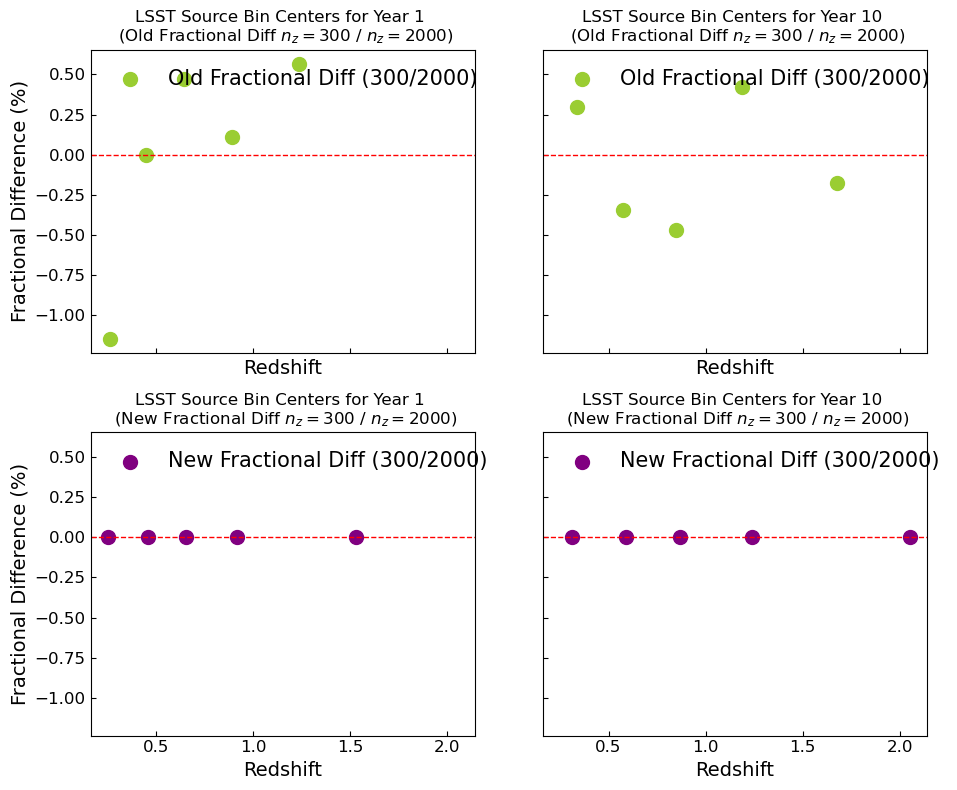

In [107]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "normalized"
num_z_300, num_z_2000 = 300, 2000  # Bin resolutions to compare

# Define colors for fractional difference
colors = {"old": "yellowgreen", "new": "purple"}

# Create 2x2 subplots: Top row (old fractional diff), Bottom row (new fractional diff)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for row_idx, method in enumerate(["old", "new"]):  # Old = row 0, New = row 1
    for col_idx, year in enumerate(years):  # Year 1 = col 0, Year 10 = col 1
        ax = axes[row_idx, col_idx]

        # Extract bin centers for sources
        if method == "old":
            centers_300 = np.array(old_data[year][norm_key][num_z_300]["source_bin_centers"]["sources"])
            centers_2000 = np.array(old_data[year][norm_key][num_z_2000]["source_bin_centers"]["sources"])
        else:
            centers_300 = np.array([new_data[year][norm_key][num_z_300]["source_bin_centers"][k]
                                    for k in sorted(new_data[year][norm_key][num_z_300]["source_bin_centers"].keys())])
            centers_2000 = np.array([new_data[year][norm_key][num_z_2000]["source_bin_centers"][k]
                                    for k in sorted(new_data[year][norm_key][num_z_2000]["source_bin_centers"].keys())])

        # Compute fractional difference safely
        frac_diff = 100 * np.divide((centers_300 - centers_2000), centers_2000,
                                    out=np.full_like(centers_300, np.nan),
                                    where=centers_2000 != 0)  # Convert to percentage

        # Scatter plot for fractional difference
        ax.scatter(centers_2000, frac_diff, color=colors[method], s=100,
                   label=f"{method.capitalize()} Fractional Diff (300/2000)")

        # Reference line at fractional difference = 0
        ax.axhline(0.0, linestyle="--", color="red", lw=1)

        # Labels, titles, and styling
        ax.set_xlabel("Redshift", fontsize=14)
        if col_idx == 0:
            ax.set_ylabel("Fractional Difference (%)", fontsize=14)

        ax.set_title(f"LSST Source Bin Centers for Year {year} \n ({method.capitalize()} Fractional Diff $n_z = 300$ / $n_z = 2000$)", fontsize=12)
        ax.tick_params(direction="in", labelsize=12)
        ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.show()


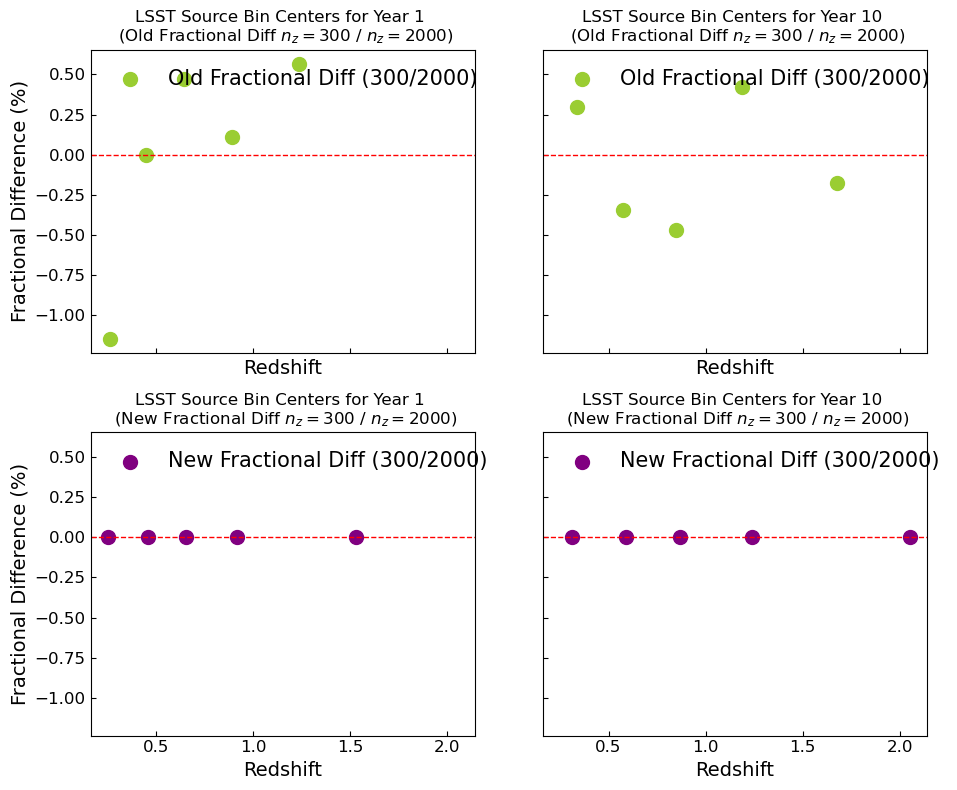

In [108]:
# Define parameters
years = ["1", "10"]  # Compare Year 1 and Year 10
norm_key = "raw"
num_z_300, num_z_2000 = 300, 2000  # Bin resolutions to compare

# Define colors for fractional difference
colors = {"old": "yellowgreen", "new": "purple"}

# Create 2x2 subplots: Top row (old fractional diff), Bottom row (new fractional diff)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for row_idx, method in enumerate(["old", "new"]):  # Old = row 0, New = row 1
    for col_idx, year in enumerate(years):  # Year 1 = col 0, Year 10 = col 1
        ax = axes[row_idx, col_idx]

        # Extract bin centers for sources
        if method == "old":
            centers_300 = np.array(old_data[year][norm_key][num_z_300]["source_bin_centers"]["sources"])
            centers_2000 = np.array(old_data[year][norm_key][num_z_2000]["source_bin_centers"]["sources"])
        else:
            centers_300 = np.array([new_data[year][norm_key][num_z_300]["source_bin_centers"][k]
                                    for k in sorted(new_data[year][norm_key][num_z_300]["source_bin_centers"].keys())])
            centers_2000 = np.array([new_data[year][norm_key][num_z_2000]["source_bin_centers"][k]
                                    for k in sorted(new_data[year][norm_key][num_z_2000]["source_bin_centers"].keys())])

        # Compute fractional difference safely
        frac_diff = 100 * np.divide((centers_300 - centers_2000), centers_2000,
                                    out=np.full_like(centers_300, np.nan),
                                    where=centers_2000 != 0)  # Convert to percentage

        # Scatter plot for fractional difference
        ax.scatter(centers_2000, frac_diff, color=colors[method], s=100,
                   label=f"{method.capitalize()} Fractional Diff (300/2000)")

        # Reference line at fractional difference = 0
        ax.axhline(0.0, linestyle="--", color="red", lw=1)

        # Labels, titles, and styling
        ax.set_xlabel("Redshift", fontsize=14)
        if col_idx == 0:
            ax.set_ylabel("Fractional Difference (%)", fontsize=14)

        ax.set_title(f"LSST Source Bin Centers for Year {year} \n ({method.capitalize()} Fractional Diff $n_z = 300$ / $n_z = 2000$)", fontsize=12)
        ax.tick_params(direction="in", labelsize=12)
        ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.show()
